<h1><center>Estimating Travel Time Distance Matrices, Access, and Coverage Scores  
    for Chicago's Health Facilities </center></h1>   

<div style="text-align: center"> 
Irene Farah 
irenef@uchicago.edu  
Center for Spatial Data Science  
University of Chicago  
June 11, 2018 
</div>

---
**(>>>) = missing information **  

The purpose of this document is twofold: present the comprehensive methodology for efficiently estimating travel time network distances and illustrating its usage. Specifically, we create an open-source backend infrastructure for estimating travel time network distances (walking, driving, and <span style="color:magenta"> **(PENDING)** <span style="color:black"> biking and transit) and providing the framework for calculating accessibility and coverage scores. The accesibility score focuses on the attributes of the origins while the coverage score focuses on the attributes from the destinations of interest. Moreover, this framework also allows subsetting of the data according to the user's specific questions of interest. These analyses create a powerful tool for supporting stakeholders and researchers in improving transparent decision-making processes and in understanding the issues of unequal spatial access.

In this particular example, we analyze health facilities in the city of Chicago. The data is provided from http://makosak.github.io/chihealthaccess/index.html. However, this demo can be used with the user's own data, by specifying the destinations and the spatial area of analysis of interest.   

^ More seasoned users can download and edit python scripts directly in https://github.com/GeoDaCenter/contracts.

**The document is organized as follows:**

1) First, an overview of the conceptual design is outlined. [(go to section)](#overview)  

2) Then, we introduce the **code** of the travel time distance network matrices [(go to section)](#code) followed by the description of the travel time measures, access score (origin-focused), and coverage score (destination-focused). The coding is included in the demo to show which arguments and commands can be specified by the user. There are specific parameters or sections that might be tweaked depending on the user's interest. <span style="color:red">**Red text** <span style="color:black"> indicates where the user can modify the code while <span style="color:LimeGreen"> **green text** <span style="color:black"> indicates the "on the fly" specifications the user can define. The rest can be ran as it is currently shown. The process depends on scripts of code outlined below:

- create a point to point shortest path [**(p2p)**](#p2p) algorithm for creating the parcel-to-parcel distance matrix by travel mode (walking and driving).
- create a score infrastructure [**(ScoreModel)**](#scoremodel) for creating the access score and per capita spending, using the ModelData class (parent of HSSA and PCSpend Models created below). This class allows users to build their own score according to their particular interests.
- create models [**(CommunityAnalytics)**](#communityanalytics) for creating aggregate measures of the access score and coverage score(creating the HSSA and PCSpend Models classes). 

3) Third, the demo for generating the **distance matrix** from blocks to health facilities is shown for both approaches and the scores are calculated. [(go to section)](#distance)  

4) Fourth, the **access and coverage scores** are generated, depicting examples of different types of **subsetting** and **aggregation** and illustrating the usage of these scores. [(go to section)](#scores)  

5) Finally, travel time measures are shown.  [(go to section)](#aggregation)  

6) Comparison (validation and calibration) with GoogleMaps. <span style="color:magenta"> **(PENDING)**

7) Extra technical notes that might provide more in detail insight. [(go to section)](#notes)  

<a id='overview'></a>

## Overview  
---
Why is this method better? This method comprehensively measures access more efficiently under an open-source framework compared to the extant state of the art options such as Valhalla and OSRM.  

Generating large shortest path matrices for different transit types is an important tool for spatial data science, but does not currently have a solution that is open source, highly scalable and efficient. Several tools currently exist which fill a similar purpose to this software package. OSRM, Valhalla and Google Maps, among other services, offer matrix APIs to compute the shortest path distance for datasets but the open-source solutions break down when applied to very large datasets.

Each of the above services caps the number of entries in a request at 25-50, meaning that generating a matrix with 500,000 rows requires breaking the original matrix into millions of submatrices and making millions of individual queries. This approach works well for small datasets, but includes substantial overhead which is prohibitive on a large scale. The point to point shortest path algorithm (p2p) can generate matrices between a set of source and destination points (or source-source) in 2 lines of code, efficiently and with a low memory footprint.

This code generates a driving shortest path matrix for 46,265 blocks in Chicago in ~14 minutes (18 minutes for walking) whereas the same task took > 18 hours using MapZen's Valhalla. For this particular dataset, the mean difference between time values for the driving shortest path matrix and Google Maps' Matrix API is 2 minutes.

Specifically, there are two routes the user can take for getting the travel distances: Creating **symmetric** or **asymmetric** matrices. As mentioned above, symmetric matrices are estimated source to source, while asymmetric matrices calculate origin to destination. The user can generate a symmetric distance travel matrix and snap the points of interest to the matrix or create an asymmetric distance matrix that already incorporates origin and destination. The symmetric approach is more appropriate when you need to calculate several scores (across years or different types of scores) for the same area and at the same level of analysis.  

After obtaining the distance travel times from origins to destinations (in this case, from the centroids of blocks to the health facilities), the user can calculate the access score from each block to health facilities or the destination coverage score. Moreover, it is important to emphasize that the following framework allows the user to generate any type of score, suiting each person's needs.  


<a id='code'></a>

--- 
<h1><center>CODE</center></h1>  


** Setup the environment**:  

Open a terminal, go to directory where you want to save the folder and run:  
`$ git clone https://github.com/GeoDaCenter/contracts.git`  
    
Go the contracts > analytics folder:  
`$ cd contracts/analytics`  

Install `python3` and `pip` (if not installed already).   

Run `pip3 install -r requirements.txt`, also in the cloned directory. If you get any errors, try running `pip3 install -r requirements.txt --upgrade`.  

Run `python3 setup.py install` in the cloned directory (If you are on linux, throw a `sudo` in front).  

**Please make sure:**  
- This notebook is within the analytics folder, so it can run under the required settings.  
- Save your .csv origin (boundaries) and destination (facilities/businesses) files under the under the analytics > resources folder.
- Both origin and destination files are under the same coordinate reference system and that it is EPSG:4326 (WGS 84).

The package is written in Python 3.6, C++ 11 and Cython by Logan Noel (https://www.linkedin.com/in/lmnoel/).  
Currently, the only supported operating systems are MacOS and Ubuntu (if you don't have either, a guide for installing Ubuntu 16.04 LTS is at the bottom of this README.)

In [1]:
# Install libraries 
import numpy as np
import multiprocessing
import scipy.spatial
from sklearn.neighbors import NearestNeighbors
from geopy.distance import vincenty
import pandana
from jellyfish import jaro_winkler
from pandana.loaders import osm
import pandas as pd
import time, sys, os.path, csv, json, logging, os, psutil
try:
    from pyengine import *
except:
    print('Unable to import pyengine. Try running setup.py again')
    
#For p2p calibration
import requests
import random

#For ScoreModel
import geopandas as gpd
from shapely.geometry import Point
import math
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread, Lock

#For CommunityAnalytics
import os.path
import matplotlib.pyplot as pltcat
import matplotlib.patches as mpatches
import copy
from matplotlib import mlab
from scipy import stats
import matplotlib as mpl
from geopandas import GeoDataFrame



In [9]:
%%capture 
#To collapse lines in Jupyter Notebook 
! pip install jupyter_nbextensions_configurator
! jupyter contrib nbextension install --user
! jupyter nbextensions_configurator enable --user
! sys.exit()

### Point to point (p2p) algorithm  

The following script creates two classes: **pyTMatrix** and **TransitMatrix**.

The **pyTMatrix** generates the environment in Python for estimating the time travel matrix by creating a wrapper for C++. 

**Framework for p2p algorithm:**  

The **TransitMatrix** unified class manages all aspects of computing a transit time matrix where matrices can be symmetric or assymetric (as mentioned above). Therefore, load one input file if the user wants a symmetric distance graph, or two for an asymmetric matrix. Particularly, this class account for all the details that entail specifying the speed limits, creating the bounding box for the area of interest in order to run the OSM query and calculate the shortest path matrix.  

In order to calculate the network distance matrix, first, the code extracts the extreme value of latitude/longitude from the source input table to create a bounding box of the area of interest. The size of the bounding box is increased by 'epsilon', to avoid cutting off the network of datapoints near the boundary of the bounding box. Please view the epsilon calibration to assess the appropriate value of epsilon for each estimation. <span style="color:magenta"> **(PENDING)**

OSM's data structure is composed of four elements: nodes, ways, relations, and tags.
Nodes are latitude and longitude coordinates (projected in WGS 84) that represent the map’s features. Ways are a list of nodes that compose the geometry features (i.e. point, line, polygon) within a map, depicting streets, waterways, parks, etc. Relations express the relationship between nodes and ways. Lastly, tags are attached to nodes, mays or relations, storing metadata about the map objects.  

Then, the OpenStreetMap network is downloaded using the area of the previously determined bounding box. (^The complexity of the network depends on the number of nodes on the generated bounding box (i.e. the area of interest defined by the latitude and longitude coordinates). Therefore, the number of observations should not affect the efficiency of the running times.) In order to get the distances from OSM, OSM net calculates the distances of the relations, creating the edges that are queried for the travel time estimation. To estimate these distances, the user has to specify data into a WGS 84 projection.  

Several parameters should be taken into account when calculating the distance network matrix:  
* The _network type_ can be determined for walking or driving <span style="color:magenta"> **(PENDING)** <span style="color:black"> biking and transit).  

* Thresholds can be adjusted and are considered in the calculation of the distance matrix: the _average walking speed_ is 5 km/h (3 mph) and the default _average driving speed_ is of 40 km/h (25 mph).  This parameter might be specified differently for different populations.  * The City of Chicago estimates an average block dimension of 660 feet (200 m) by 330 feet (100 m).(https://www.cityofchicago.org/dam/city/depts/cdot/StreetandSitePlanDesignStandards407.pdf) STREET AND SITE PLAN DESIGN STANDARDS (2007:pg 2.) These dimensions might change across cities. >>> (Include table with conversions. Or reference to data on other cities) Therefore, the average walking speed of 3 mph estimates that a person, on average, walks a block in 72 to 144 seconds (1.2 - 2.4 min) to walk a block.
    
* The _last mile_ correction is the distance that is not accounted for when calculating the shortest path from the centroid of the block to the actual network; therefore, the wanting extra distance is added to the travel time distance(>>>). 
    
* The files needed for obtsining the travel time distance matrices are the following:  
     * Only mandatory file: Single or separate file: origin + destination points of addresses. (User should make sure the projection is in EPSG 4326.)
     * Table containing population data (in case the user is interested in future aggregation).
     * Shapefile of finer spatial area ID  (in case the user is interested in future aggregation).
     * Moreover, if the network type is driving, the edge traversal speed is drawn from a table of speed limits and street names that must be supplied separately.  

* Also for walking and driving, a node penalty of X seconds (>>>) can also be specified by the user for the number of intersections within the area of analysis. The logic is that having more intersections will increase the travel time due to crossings. However, by doing a time travel calibration between the p2p algorithm and GoogleMaps, there was no need for adding penalities for the city of Chicago. The calibration can be assessed for different cities by using a random set of latitude and longitude points and comparing both estimated travel times for p2p (using the default average speeds and speed limits) and the GoogleMaps API. <span style="color:magenta"> **(PENDING)** <span style="color:black"> (Show table in which the calibration was tested for different cities, suggesting values for each.)>>>

* Lastly, it is important to emphasize that the network is directed, meaning that one way streets are respected and A->B and B->A can have different edge traversal speeds.

Please note that peak hour is not considered in the estimation of travel time distances. However, according to the GoogleMaps calibration, the travel time conditions we are asumming are in between rush hour and no traffic. <span style="color:magenta"> **(PENDING)**  

**OSM structure**  
In order to elucidate how the algorithm for estimating the travel time distance, a brief description of OSM's structure follows. >>>

P2P uses a k-d tree to match each point in the source and destination data to its nearest neighbor node in the OSM network, and then finds the Vincenty distance between the two points. Vincenty's formulae estimate the geodesic distance between two points according to an ellipsoidal model of the Earth. (in this case are we using the direct or indirect formula?) Haversine formulas? more accurate? 0.3%>>>  

For the travel time computation between origin and destination, Dijkstra's algorithm considers every possible route and chooses only the fastest route. Therefore, P2P also uses an adjacency list representation for Dijkstra's algorithm to find the shortest path for every node to every other node in the underlying OSM network, but it can skip doing any processing for nodes that do not have an attached source data point. The advantage of this approach is that it scales to essentially any size dataset; as opposed to the adjacency matrix representation (which can easily exceed the memory of many systems for reasonably large datasets) P2P never loads the entire network into memory at one time, meaning the memory footprint is relatively small. This also means the multithreaded performance of P2P greatly outperforms the singlethreaded performance.  

Finally, for every point in the source dataset to every point in the destination dataset, the base impedence is the cost found using Dijkstra. To the base value we add the 'last mile' inferred impedence from the source and destination points to their respective nearest nodes, determined by the Euclidean distance and a constant traversal speed. The 'last mile' is figurative; in the City of Chicago, for instance, 75 percent of block centroids were within 100 meters of the nearest OSM node and 95 percent of block centroids were within 200 meters.
 
<span style="color:red"> **Open the following code to define the _epsilon_ parameter and _threshold constants_, if needed:** 
* **Threshold constants**: walk/drive average speed, walk/drive node penalty. The **average speeds** can be specified within the **p2p_parameters.json file**.  
* **Epsilon**: Controls how large to make the network bounding box beyond your dataset. Larger epsilons result in longer computation times, but smaller epsilons result in slightly reduced accuracy at the very edges of the bounding box, especially for driving networks. The default is currently set at 0.05, which seems to balance the two reasonably well. (+/-) 0.02 will result in a large increase/decrease in computation time and accuracy. If too many values are defined as -1, it means that the epsilon is too small. Refer to the epsilon calibration to assess if this value must change and the matrix contains too many -1.


In [10]:
# Prevent user from quering OSM data for areas larger than needed 
def geo_area(lat1, lon1, lat2, lon2):
    '''
    Given the coordinates of a bounding box, return the area
    in square kilometers.
    '''

    EARTH_RADIUS = 6371
    area =  math.pi * (EARTH_RADIUS ** 2) 
    area *= abs(math.degrees(math.sin(lat1)) - math.degrees(math.sin(lat2))) 
    area *= abs(lon1 - lon2) / 180

    return area

In [4]:
# Define pyMatrix class 

class pyTMatrix(object):
    '''
    A wrapper for C++ based pandas DataFrame like object.
    '''
    def __init__(self, infile, nn_pinfile, nn_sinfile, outfile,
     N, impedence, num_threads, outer_node_rows, outer_node_cols, mode, 
     write_to_file, load_to_mem, read_from_file=False):

        GB = 1073741824
        if write_to_file and not load_to_mem:
            write_mode = 0
        elif write_to_file and load_to_mem:
            write_mode = 1
        elif not write_to_file and load_to_mem:
            write_mode = 2
        elif (read_from_file) and (not write_to_file) and (not load_to_mem):
            write_mode = 3
        if load_to_mem:
            expected_memory = int(2 * outer_node_cols * outer_node_rows / GB)
            system_memory = int(psutil.virtual_memory().total / GB)
            if expected_memory > system_memory:
                warning_text = '''WARNING: Expected memory ({} Gb) is greater than 
                available system memory ({} Gb). P2p will likely crash, 
                please run in write only mode (not load_to_mem)'''.format(expected_memory, system_memory)
                print(warning_text)

       
        self.tm = tmatrix(infile.encode('UTF-8'), nn_pinfile.encode('UTF-8'),
            nn_sinfile.encode('UTF-8'), outfile.encode('UTF-8'), N, impedence,
            num_threads, outer_node_rows, outer_node_cols, mode, write_mode)


In [5]:
# Define TransitMatrix class 
class TransitMatrix(object):
    '''
    A unified class to manage all aspects of computing a transit time matrix.
    Arguments:
        -network_type: 'walk', 'drive' or 'bike'
        -epsilon: [optional] smooth out the network edges
        -primary_input: 
    '''
    def __init__(self, network_type, epsilon=0.05, primary_input=None, 
        secondary_input=None, output_type='csv', n_best_matches=4, 
        read_from_file=None, write_to_file=False, load_to_mem=True,
        primary_hints=None, secondary_hints=None):

        self.network_type = network_type
        self.epsilon = epsilon
        self.primary_input = primary_input
        self.secondary_input = secondary_input
        self.sl_data = None
        self.primary_data = None
        self.secondary_data = None
        self.num_nodes = 0
        self.num_edges = 0
        self.nodes = None
        self.edges = None
        self.n_best_matches = n_best_matches
        self.output_type = output_type
        self.read_from_file = read_from_file
        if read_from_file:
            self.write_to_file = False
            self.load_to_mem = False
        else:
            self.write_to_file = write_to_file
            self.load_to_mem = load_to_mem

        self.network_filename = None
        self.output_filename = None
        self.nn_primary_filename = None
        self.nn_secondary_filename = None

        self.primary_hints = primary_hints
        self.secondary_hints = secondary_hints

        self.bbox = []
        self.node_pair_to_speed = {}
        self.tmatrix = None

        #CONSTANTS
        self.HUMAN_WALK_SPEED = 5 #km per hour
        self.BIKE_SPEED = 15 #km per hour
        self.ONE_HOUR = 3600 #seconds
        self.ONE_KM = 1000 #meters
        self.WALK_CONSTANT = (self.HUMAN_WALK_SPEED / self.ONE_HOUR) * self.ONE_KM
        self.WALK_NODE_PENALTY = 0
        self.BIKE_CONSTANT = (self.BIKE_SPEED / self.ONE_HOUR) * self.ONE_KM
        self.BIKE_NODE_PENALTY = 0

        self.DEFAULT_DRIVE_SPEED = 40 #km per hour
        self.DRIVE_CONSTANT = (self.DEFAULT_DRIVE_SPEED / self.ONE_HOUR) * self.ONE_KM 
        self.DRIVE_NODE_PENALTY = 0
        self.INFINITY = -1

        self.debug = False
        assert network_type != 'bike', "bike mode is temporarily disabled"
        assert network_type in ['drive', 'walk', 'bike'], "network_type is not one of: ['drive', 'walk', 'bike'] "

        assert (write_to_file or load_to_mem or read_from_file), "Need to (write_to_file and or load_to_mem) or read_from_file, can't do nothing"

    def get(self, source, dest):
        '''
        Fetch the time value associated with the source, dest pair.
        '''
        assert self.tmatrix != None, "tmatrix does not yet exist"
        try:
            return self.tmatrix.tm.get(str(source), str(dest))
        except:
            self.logger.error('Source, dest pair could not be found')


    def _load_parameters(self, filename='p2p_parameters.json'):
        '''
        Load model parameters from json.
        '''
        try:
            with open(filename) as json_data:
                params = json.load(json_data)

                self.HUMAN_WALK_SPEED = params['walk']['default_speed']
                self.WALK_NODE_PENALTY = params['walk']['node_penalty']

                self.DEFAULT_DRIVE_SPEED = params['drive']['default_speed']
                self.DRIVE_NODE_PENALTY = params['drive']['node_penalty']

                self.BIKE_SPEED = params['bike']['default_speed']
                self.BIKE_NODE_PENALTY = params['bike']['node_penalty']

                self.WALK_CONSTANT = (self.HUMAN_WALK_SPEED / self.ONE_HOUR) * self.ONE_KM
                self.BIKE_CONSTANT = (self.BIKE_SPEED / self.ONE_HOUR) * self.ONE_KM
                self.DRIVE_CONSTANT = (self.DEFAULT_DRIVE_SPEED / self.ONE_HOUR) * self.ONE_KM
        except:
            raise EnvironmentError("Necessary file: {} could not be found in current directory".format(filename))


    def set_logging(self, debug=False):
        '''
        Set the proper logging and debugging level.
        '''

        if debug:
            logging.basicConfig(level=logging.DEBUG)
            self.debug = True
        else:
            logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

        if debug:
             self.logger.debug("Running in debug mode") 

    def _get_output_filename(self, keyword, extension='csv'):
        '''
        Given a keyword, find an unused filename.
        '''
        if not os.path.exists("data/"):
            os.makedirs("data/")
        filename = 'data/{}_0.{}'.format(keyword, extension)
        counter = 1
        while os.path.isfile(filename):
            filename = 'data/{}_{}.{}'.format(keyword, counter, extension)
            counter += 1

        return filename


    def _load_sl_data(self, sl_filename):
        '''
        Load speed limit data from .csv. Identify street name and speed
        limit columns.
        '''
        if not sl_filename:
            return

        #sanity check & load data
        assert (self.network_type == 'drive' and sl_filename) or (self.network_type != 'drive'), "Selected 'drive' cost model but didn't provide speed limit file"
        assert os.path.exists(sl_filename), "Unable to locate provided speed limit file"
        self.sl_data = pd.read_csv(sl_filename)
        source_data_columns = self.sl_data.columns.values

        #extract column names
        street_name = ''
        speed_limit = ''

        print('The variable names in your speed limit data set are:')
        for var in source_data_columns:
            print('> ',var)
        while street_name not in source_data_columns:
            street_name = input('Enter the street name variable name: ')
        while speed_limit not in source_data_columns:
            speed_limit = input('Enter the speed limit variable name: ')
        
        #clean the data frame
        clean_names = {street_name:'street_name',speed_limit:'speed_limit'}
        self.sl_data.rename(columns=clean_names, inplace=True)

        self.sl_data = self.sl_data[['street_name','speed_limit']]


    def _parse_csv(self, primary):
        '''
        Load source data from .csv. Identify long, lat and id columns.
        '''
        #decide which input to load
        if primary:
            filename = self.primary_input
        else:
            filename = self.secondary_input

        
        source_data = pd.read_csv(filename)
        source_data_columns = source_data.columns.values

        #extract the column names
        xcol = ''
        ycol = ''
        idx = ''


        #use the column names if we already have them
        try:
            if primary and self.primary_hints:
                xcol = self.primary_hints['xcol']
                ycol = self.primary_hints['ycol']
                idx = self.primary_hints['idx']
            elif not primary and self.secondary_hints:
                xcol = self.secondary_hints['xcol']
                ycol = self.secondary_hints['ycol']
                idx = self.secondary_hints['idx']
        except:
            pass


        print('The variables in your data set are:')
        for var in source_data_columns:
            print('> ',var)
        while xcol not in source_data_columns:
            xcol = input('Enter the x coordinate (Latitude): ')
        while ycol not in source_data_columns:
            ycol = input('Enter the y coordinate (Longitude): ')
        while idx not in source_data_columns:
            idx = input('Enter the index name: ')

        #drop nan lines
        pre_drop_indeces = source_data.index
        pre_drop = len(source_data)
        source_data.dropna(how='any', axis='index', inplace=True)
        post_drop_indeces = source_data.index

        dropped_lines = pre_drop - len(source_data)
        if dropped_lines:
            self.logger.warning("Dropped {} lines that were NaN".format(dropped_lines))
            print('The following indices were dropped:', set(post_drop_indeces) - set(pre_drop_indeces))

        #set index and clean
        source_data.set_index(idx, inplace=True)
        source_data.rename(columns={xcol:'x',ycol:'y'},inplace=True)
        source_data.index = source_data.index.map(str)
        if primary:
            self.primary_data = source_data[['x','y']]
        else:
            self.secondary_data = source_data[['x','y']]


    def _load_inputs(self):
        '''
        Load one input file if the user wants a symmetric
        distance graph, or two for an asymmetric graph.
        '''
        if not os.path.isfile(self.primary_input):
            self.logger.error("Unable to find primary csv.")
            sys.exit()
        if self.secondary_input:
            if not os.path.isfile(self.secondary_input):
                self.logger.error("Unable to find secondary csv.")
                sys.exit()
        try:
            self._parse_csv(True)
            if self.secondary_input:
                self._parse_csv(False)

        except:
            self.logger.error("Unable to find matching network. Did you reverse lat/long?")
            sys.exit()


    def _get_bbox(self):
        '''
        Figure out how to set the upper left and lower right corners
        of the bounding box which
        is used to request a streed/road/path network from OSM, 
        including a small correction to account for nodes that might
        lay just beyond the most distant data points.
        '''
        if self.secondary_input:
            composite_x = list(self.primary_data.x) + list(self.secondary_data.x)
            composite_y = list(self.primary_data.y) + list(self.secondary_data.y)
        else:
            composite_x = list(self.primary_data.x)
            composite_y = list(self.primary_data.y)

        if max(composite_x) > 0:
            ul_x = max(composite_x) + self.epsilon
        else:
            ul_x = max(composite_x) - self.epsilon
        if min(composite_x) > 0:
            lr_x = min(composite_x) - self.epsilon
        else:
            lr_x = min(composite_x) + self.epsilon

        if max(composite_y) > 0:
            ul_y = max(composite_y) - self.epsilon
        else:  
            ul_y = max(composite_y) - self.epsilon
        if min(composite_y) > 0:
            lr_y = min(composite_y) + self.epsilon
        else:
            lr_y = min(composite_y) + self.epsilon

        self.bbox = [ul_x, ul_y, lr_x, lr_y]
        self.logger.debug('set bbox: {}'.format(self.bbox))


    def _set_output_filename(self, output_filename):
        '''
        Set the output filename to a default value or given.
        '''
        if not output_filename:
            key_phrase = '{}_full_results'.format(self.network_type)
            self.output_filename = self._get_output_filename(key_phrase, 
                self.output_type)
        else:
            self.output_filename = output_filename


    def _get_thread_limit(self):
        '''
        Determine if the algorithm should be throttled
        based on the available system memory and number of cores.
        Returns: int (num threads to use)
        '''

        no_cores = multiprocessing.cpu_count()
        if no_cores > 2:
            no_cores -= 1
        else:
            no_cores = 1

        self.available_threads = no_cores


    def _clean_speed_limits(self):
        '''
        Map road segments to speed limits.
        '''
        edges = self.edges
        sl_file = self.sl_data

        start_time = time.time()

        #clean the table and standardize names
        sl_file.dropna(inplace=True, axis=0, how='any')
        sl_file['street_name'] = sl_file['street_name'].str.upper()
        edges['name'].replace(np.nan, 'PRIVATE', regex=True, inplace=True)
        edges['name'] = edges['name'].str.upper()
        sl_file = sl_file[sl_file['speed_limit'] > 0]
        
        #load mappings for easy use
        limits = {}
        for row in sl_file.itertuples():
            limits[row[1]] = row[2]

        #extract edge names/ids from OSM network and assign defaut speed
        STR_NAME = edges.columns.get_loc('name') + 1
        network_streets = {}
        for data in edges.itertuples():
            network_streets[data[STR_NAME]] = 25
        
        remaining_names = set(limits.keys())

        perfect_match = 0
        great_match = 0
        good_match = 0
        non_match = 0

        #assign default value
        network_streets['PRIVATE'] = self.DEFAULT_DRIVE_SPEED

        #attempt to match edges in OSM to known street names
        #and assign corresponding speed limit
        for name in network_streets.keys():
            if name != 'PRIVATE':
                if name in remaining_names:
                    network_streets[name] = limits[name]
                    perfect_match += 1
                else:
                    best_distance = 0
                    best_match = None
                    for potential_match in remaining_names:
                        distance = jaro_winkler(name, potential_match)
                        if distance >= 0.97:
                            best_distance = distance
                            best_match = potential_match
                            great_match += 1
                            break
                        if distance > best_distance:
                            best_distance = distance
                            best_match = potential_match
                    if best_match and best_distance > 0.9:
                        network_streets[name] = limits[best_match]
                        good_match += 1
                    else:
                        non_match += 1
                        network_streets[name] = 25


        node_pair_to_speed = {}
        for data in edges.itertuples():
            if data[STR_NAME] in network_streets.keys():
                speed =  network_streets[data[STR_NAME]]
            else:
                speed = 25
            node_pair_to_speed[(data[0][0], data[0][1])] = speed
            node_pair_to_speed[(data[0][1], data[0][0])] = speed 

        self.logger.info('''Matching street network completed in 
            {:,.2f} seconds: {} perfect matches, {} near perfect matches,
            {} good matches and {} non matches'''.format(time.time() - start_time, 
                perfect_match, great_match, good_match, non_match))

        self.node_pair_to_speed = node_pair_to_speed

      
    def _cost_model(self, distance, sl):
        '''
        Return the edge impedence as specified by the cost model.
        '''
        if self.network_type == 'walk':
            return int((distance / self.WALK_CONSTANT) + self.WALK_NODE_PENALTY)
        elif self.network_type == 'bike':
            return int((distance / self.BIKE_CONSTANT) + self.BIKE_NODE_PENALTY)
        else:
            if sl:
                edge_speed_limit = sl
            else:
                #if we weren't provided speed limit data, we use defaults
                #ideally, never want to be here
                self.logger.warning('Using default drive speed. Results will be inaccurate')
                edge_speed_limit = self.DEFAULT_DRIVE_SPEED
            drive_constant = (edge_speed_limit / self.ONE_HOUR) * self.ONE_KM
            return int((distance / drive_constant) + self.DRIVE_NODE_PENALTY) 


    def _request_network(self):
        '''
        Fetch a street network from OSM that encompasses the data points.
        Writes three .csv files:
            distance_matrix: matrix representing the distance from each point in
            the OSM network to every other point (in meters)
            nodes: list of all nodes in the network
            edges: list of all edges in the network
        '''
        
        self.network_filename = self._get_output_filename("raw_network")
        self._get_bbox()

        #query OSM
        try:
            self.nodes, self.edges = osm.network_from_bbox(self.bbox[0], 
                self.bbox[1], self.bbox[2], self.bbox[3],
                network_type=self.network_type)
        except:
            request_error = '''Error trying to download OSM network. 
            Did you reverse lat/long? 
            Is your network connection functional?
            '''
            self.logger.error(request_error)
            sys.exit()


        if self.network_type == 'drive':
            self._clean_speed_limits()


        self.num_nodes = len(self.nodes)
        self.num_edges = len(self.edges)

        start_time = time.time()

        #map index name to position
        node_index_to_loc = {}
        for i, index_name in enumerate(self.nodes.index):
            node_index_to_loc[index_name] = i

        DISTANCE = self.edges.columns.get_loc('distance') + 1
        FROM_IDX = self.edges.columns.get_loc('from') + 1
        TO_IDX = self.edges.columns.get_loc('to') + 1
        ONEWAY = self.edges.columns.get_loc('oneway') + 1

        #create a mapping of each node to every other connected node
        #transform them by cost model as well
        with open(self.network_filename, 'w') as csvfile:
            writer = csv.writer(csvfile)
            for data in self.edges.itertuples():
                from_idx = data[FROM_IDX]
                to_idx = data[TO_IDX]
                if self.node_pair_to_speed:
                    impedence = self._cost_model(data[DISTANCE], 
                        self.node_pair_to_speed[(from_idx, to_idx)])
                else:
                    impedence = self._cost_model(data[DISTANCE], None)
                oneway = data[ONEWAY]
                
                writer.writerow([node_index_to_loc[from_idx], 
                    node_index_to_loc[to_idx], impedence])

                if oneway != 'yes':
                    writer.writerow([node_index_to_loc[to_idx], 
                        node_index_to_loc[from_idx], impedence])

        
        self.logger.info("Prepared raw network in {:,.2f} seconds and wrote to: {}".format(time.time() - start_time, self.network_filename))


    def _calc_shortest_path(self):
        '''
        Outsources the work of computing the shortest path matrix
        to a C++ module.
        '''

        start_time = time.time()

        #if we are provided a .csv shortest path matrix, load it 
        #to memory
        if self.read_from_file:
            try:
                self.tmatrix = pyTMatrix(self.read_from_file,
                    "none", "none", "none", 0, 0.0, 1, 0, 0, 0, 
                    write_to_file=False, load_to_mem=False, read_from_file=True)
                logger_vars = time.time() - start_time
                self.logger.info('Shortest path matrix loaded from disk in {:,.2f} seconds'.format(logger_vars))
                return
            except:
                self.logger.error('Unable to load matrix from file')
                sys.exit()

        #determine initialization conditions for generating matrix
        if self.network_type == 'walk':
            imp_val = self.WALK_CONSTANT
        elif self.network_type == 'bike':
            imp_val = self.BIKE_CONSTANT
        else:
            imp_val = self.DRIVE_CONSTANT


        outer_node_rows = len(self.primary_data)
        if self.secondary_input:
            outer_node_cols = len(self.secondary_data)
        else:
            outer_node_cols = len(self.primary_data)
        if self.output_type == 'csv':
            nearest_neighbors = 0
        else:
            nearest_neighbors = self.n_best_matches
    
        if self.write_to_file:
            self.logger.info('Writing to file: {}'.format(self.output_filename))
        
        self.tmatrix = pyTMatrix(self.network_filename,
            self.nn_primary_filename, self.nn_secondary_filename,
            self.output_filename, self.num_nodes, imp_val, 
            self.available_threads, outer_node_rows, outer_node_cols, 
            nearest_neighbors, write_to_file=self.write_to_file, 
            load_to_mem=self.load_to_mem, read_from_file=False)
        
        logger_vars = time.time() - start_time
        self.logger.info('Shortest path matrix computed in {:,.2f} seconds'.format(logger_vars))
    

    def _match_nn(self, secondary):
        '''
        Maps each the index of each node in the raw distance 
        matrix to a tuple
        containing (source_id, distance), where
        source_id is a member of the primary_source
        or secondary_source and distance is the number of meters
        between the (primary/secondary) source and its nearest OSM node.
        '''

        if secondary:
            self.nn_secondary_filename = self._get_output_filename("nn_secondary")
            data = self.secondary_data
            filename = self.nn_secondary_filename
        else:
            self.nn_primary_filename = self._get_output_filename("nn_primary")
            self.nn_secondary_filename = self.nn_primary_filename
            data = self.primary_data
            filename = self.nn_primary_filename

        nodes = self.nodes[['x', 'y']]

        node_indeces = nodes.index
        start_time = time.time()
        KM_TO_METERS = 1000

        #make a kd tree in the lat, long dimension
        node_array = pd.DataFrame.as_matrix(nodes)
        kd_tree = scipy.spatial.cKDTree(node_array)

        #map each node in the source/dest data to the nearest
        #corresponding node in the OSM network
        #and write to file
        with open(filename, 'w') as csvfile_w:
            writer = csv.writer(csvfile_w)
            for row in data.itertuples():
                origin_id, origin_y, origin_x = row
                latlong_diff, node_loc = kd_tree.query([origin_x, origin_y],k=1)
                node_number = node_indeces[node_loc]
                distance = vincenty((origin_y, origin_x), (nodes.loc[node_number].y, 
                    nodes.loc[node_number].x)).km

                distance = int(distance * KM_TO_METERS)

                writer.writerow([node_loc, origin_id, distance])

        self.logger.info('Nearest Neighbor matching completed in {:,.2f} seconds'.format(time.time() - start_time))



    def _cleanup_artifacts(self, cleanup):
        '''
        Cleanup the files left over from computation.
        '''
        if not cleanup:
            return
        files = os.listdir("data")
        for file in files:
            if 'raw_network' in file or 'nn_primary' in file or 'nn_secondary' in file:
                os.remove('data/' + file)
        if os.path.isfile('p2p.log'):
            os.remove('p2p.log')
        if os.path.isfile('logs'):
            os.rmdir('logs')
        if os.path.isfile('__pycache__'):
            os.rmdir('__pycache__')
        print("Cleaned up calculation artifacts")


    def process(self, speed_limit_filename=None, output_filename=None, 
                cleanup=True, debug=False):
        '''
        Process the data.
        '''

        self.set_logging(debug)

        #load from file if given
        if self.read_from_file:
            self.logger.info('Loading data from file: {}'.format(self.read_from_file))
            self._calc_shortest_path()
            return

        #sanity check
        if self.network_type == 'drive':
            if not speed_limit_filename:
                self.logger.error('Network type is drive. Must provide speed limit table')
                sys.exit()
              

        self.logger.info("Processing network ({}) in format: {} with epsilon: {}".format(self.network_type, 
            self.output_type, self.epsilon))

        self._load_inputs()

        self._get_thread_limit()

        self._load_parameters()

        self._load_sl_data(speed_limit_filename)

        start_time = time.time()

        self._set_output_filename(output_filename)

        self._request_network()

        self._match_nn(False)
        if self.secondary_input:
            self._match_nn(True)

        self._calc_shortest_path()

        self._cleanup_artifacts(cleanup)

        self.logger.info('All operations completed in {:,.2f} seconds'.format(time.time() - start_time))

## P2P Calibration 
put at the end of p2p in order to import transitmatrix

We use Graphhopper in order to test the p2p calibration. A Graphhopper API is required to run this process and it can be obtained here:
https://graphhopper.com/api/1/docs/FAQ/

Note: You can also use a GoogleMaps API.


Show the mean and stddev of the difference between p2p's route time
and GraphHopper's route time, in seconds.

IMPORTANT: To use this, must have a valid GraphHopper Matrix API key
saved in a text file in this directory called GRAPHHOPPER_API_KEY.txt

Positive differences indicate p2p's route was longer, negative times indicates
that p2p's route was shorter.

In [4]:
# P2P Calibration 
#need this because p2p and graphhopper use synonyms for 
#vehicle/route types
p2p_to_graphhopper_type_names = {
    'drive' : 'car',
    'walk' : 'foot',
    'bike' : 'bike'
}

def sample_one_matrix(df, tm, network_type, api_key):
    '''
    Test one ditance matrix
    '''

    base_url = "https://graphhopper.com/api/1/matrix"
    first = True
    for data in df.itertuples():
        x_data = data[4]
        y_data = data[5]
        if first:
            point_string = "?point={},{}".format(x_data, y_data)
            first = False
        else:
            point_string = "&point={},{}".format(x_data, y_data)

        base_url += point_string

    param_string = "&type=json&vehicle={}&debug=true&out_array=times&key={}".format(network_type, api_key)
    base_url += param_string


    try:
        r = requests.get(base_url)

        results = r.json()['times']
    except:
        print('there was a problem fetching from GraphHopper. Exiting...')
        sys.exit()


    already_checked = set()
    diffs = []
    for i, row in enumerate(df.index):
        for j, col in enumerate(df.index):
            if (row, col) not in already_checked and row != col:
                calculated_time = tm.get(row, col)
                actual_time = results[i][j]
                diff = calculated_time - actual_time
                diffs.append(diff)
                already_checked.add((row, col))
                already_checked.add((col, row))

    stddev = np.std(diffs)
    mean = np.mean(diffs)


    print('diffs mean: {}, stddev: {}'.format(mean, stddev))


def calibrate(network_type='walk', input_file='resources/LEHD_blocks.csv', 
    sl_file='resources/condensed_street_data.csv', n=1):
    '''
    Show the mean and stddev of the difference between p2p's route time
    and GraphHopper's route time, in seconds.

    IMPORTANT: To use this, must have a valid GraphHopper Matrix API key
    saved in a text file in this directory called GRAPHHOPPER_API_KEY.txt

    Positive differences indicate p2p's route was longer, negative times indicates
    that p2p's route was shorter.
    '''
    if network_type == 'drive':
        assert sl_file is not None, 'must provide sl_file for use with driving network calibration'
    with open('GRAPHHOPPER_API_KEY.txt', 'r') as api_file:
        api_key = api_file.read()
        api_key = api_key.strip()
    gh_type_name = p2p_to_graphhopper_type_names[network_type]

    tm = TransitMatrix(network_type=network_type, primary_input=input_file)
    if network_type == 'drive':
        tm.process(speed_limit_filename=sl_file)
    else:
        tm.process()

    #extract the column names
    xcol = ''
    ycol = ''
    idx = ''

    df = pd.read_csv(input_file)

    print('The variables in your data set are:')
    df_cols = df.columns.values
    for var in df_cols:
        print('> ',var)
    while xcol not in df_cols:
        xcol = input('Enter the x coordinate (Latitude): ')
    while ycol not in df_cols:
        ycol = input('Enter the y coordinate (Longitude): ')
    while idx not in df_cols:
        idx = input('Enter the index name: ')

    df.rename(columns={xcol:'x',ycol:'y', idx:'idx'},inplace=True)
    df.set_index('idx', inplace=True)

    for i in range(n):

        sample_one_matrix(df.sample(24), tm, gh_type_name, api_key)
    


In [5]:
calibrate(network_type='walk',
          input_file='resources/LEHD_subset.csv',
          sl_file='resources/condensed_street_data.csv',
          n=1)

INFO:p2p:Processing network (walk) in format: csv with epsilon: 0.05


The variables in your data set are:
>  Unnamed: 0
>  BLOCKID10
>  CE01_2014
>  POP10
>  lat
>  long
>  community
Enter the x coordinate (Latitude): lat
Enter the y coordinate (Longitude): long
Enter the index name: BLOCKID10


INFO:osmnet:Requesting network data within bounding box from Overpass API in 1 request(s)
INFO:osmnet:Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](41.71725230,-87.61995200,41.86671280,-87.56538850);>;);out;'}"


Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](41.71725230,-87.61995200,41.86671280,-87.56538850);>;);out;'}"


INFO:osmnet:Downloaded 4,240.9KB from www.overpass-api.de in 4.57 seconds
INFO:osmnet:Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 4.63 seconds


Downloaded 4,240.9KB from www.overpass-api.de in 4.57 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 4.63 seconds


INFO:osmnet:Returning OSM data with 25,924 nodes and 6,330 ways...


Returning OSM data with 25,924 nodes and 6,330 ways...


INFO:osmnet:Edge node pairs completed. Took 6.92 seconds
INFO:osmnet:Returning processed graph with 10,933 nodes and 16,864 edges...
INFO:osmnet:Completed OSM data download and Pandana node and edge table creation in 11.99 seconds
INFO:p2p:Prepared raw network in 0.06 seconds and wrote to: data/raw_network_0.csv


Edge node pairs completed. Took 6.92 seconds
Returning processed graph with 10,933 nodes and 16,864 edges...
Completed OSM data download and Pandana node and edge table creation in 11.99 seconds


INFO:p2p:Nearest Neighbor matching completed in 0.18 seconds
INFO:p2p:Shortest path matrix computed in 0.21 seconds
INFO:p2p:All operations completed in 12.44 seconds


Cleaned up calculation artifacts
The variables in your data set are:
>  Unnamed: 0
>  BLOCKID10
>  CE01_2014
>  POP10
>  lat
>  long
>  community
Enter the x coordinate (Latitude): lat
Enter the y coordinate (Longitude): long
Enter the index name: BLOCKID10
diffs mean: 28.297101449275363, stddev: 140.40755426951296


In [74]:
# Load the travel time distance matrix and assess dimensions:  
df = pd.read_csv('data/walk_asym_health.csv')
df.shape

## Epsilon Calibration

In [1]:
#Identify percentage of values outside epsilon:
p_eps=((df.groupby('1').count()).iloc[0][0])/len(df)

In [12]:
print ("Of the total matrix ","{0:.2f}%".format(p_eps* 100),"of the values are outside the bounding box. If the value is below 1% it seems epsilon is appropriate for this particular dataset.")

Of the total matrix  0.22% of the values are outside the bounding box. If the value is below 1% it seems epsilon is appropriate for this particular dataset.


<a id='scoremodel'></a>

### Score Model: Model Infrastructure  and Travel Time Distance Measures

The following script creates the class: **ModelData**

The **ModelData** parent class creates the basis for more advanced geospatial models like HSSAModel and PCSpendModel that create the access and coverage scores. This section provides the infrastructure for manipulating the inherited travel time distance matrix. Therefore, the user can build any model from this class. 
Travel time distance measures are incorporated as extensions in this section including:  
* Travel time distance aggregated by population  
* Nearest neighbor travel times by category  
* Count of destinations by a 30 minute buffer (walking)  

The user will have to specify the previously created travel time distance matrix manually. However, if it is not supplied, it will calculate it 'on the fly'. 

In [6]:
# Define ModelData class 

class ModelData(object):
    '''
    A parent class to hold/process data for more advanced geospatial
    models like HSSAModel and PCSpendModel. The 'upper' argument in
    the __init__ is the time (in minutes), above which a source and dest
    are considered to be out of range of each other.
    '''

    def __init__(self, network_type, upper):
        self.network_type = network_type
        self.sp_matrix = None
        self.dests = None
        self.sources = None
        self.category_set = None
        self.source2dest = {}
        self.dest2source = {}
        self.dest2cats = {}
        self.cat2dests = {}
        self.nearest_cat_for_source = {}
        self.use_n_nearest = 10

        self.sources_nn = {}
        self.idx_2_col = {}

        self.source_id_list = []
        self.dest_id_list = []

        self.sp_matrix_good = False
        self.dests_good = False
        self.sources_good = False
        self.processed_good = False

        self.primary_hints = None
        self.secondary_hints = None

        assert network_type in ['drive', 'walk', 'bike'], 'gave invalid mode of transit. Must be one of: drive, walk, bike'
        self.upper = upper * 60 #convert minutes from input to seconds

        self.set_logging('info')


    def get_time(self, source, dest):
        '''
        Return the time, in seconds, from source to dest.
        '''
        assert self.sp_matrix_good, 'load shortest path matrix before this step'
        INF = 60000
        #try:
        time = self.sp_matrix.get(source, dest)

        #except:
        #    time = -1
        #    self.logger.warning('({},{}) is not a known source, dest pair'.format(source, dest))
        if time < 0:
            return INF
        return time


    def get_population(self, source_id):
        '''
        Return the population at a source point.
        '''
        assert self.sources_good, 'load sources before this step'

        return self.sources.loc[source_id, 'population']


    def get_target(self, dest_id):
        '''
        Return the target value at a dest point.
        '''
        assert self.dests_good, 'load dests before this step'

        return self.dests.loc[dest_id, 'target']


    def get_category(self, dest_id):
        '''
        Return the category of a dest point.
        '''
        assert self.dests_good, 'load dests before this step'

        return str(self.dest2cats[dest_id])


    def figure_name(self):
        '''
        Return a unique figure name.
        '''
        i = 0
        if not os.path.exists("figures/"):
            os.makedirs("figures/")
        fig_name = 'figures/fig_0.png'
        while (os.path.isfile(fig_name)):
            i += 1
            fig_name = 'figures/fig_{}.png'.format(i)

        return fig_name


    def process(self):
        '''
        Generate mappings for the model to ugse.
        '''

        #need to make sure we've loaded these data first
        assert self.sp_matrix_good, 'load shortest path matrix before this step'
        assert self.sources_good, 'load sources before this step'
        assert self.dests_good, 'load destinations before this step'
        self.logger.info('Processing... This could take a while')

        #pre map dest->category
        start_time = time.time()
        CAT = self.dests.columns.get_loc('category') + 1
        ID = 0
        rv = {}
        included_cats = set()
        for data in self.dests.itertuples():
            self.dest2cats[data[ID]] = str(data[CAT])
            if str(data[CAT]) in included_cats:
                self.cat2dests[data[CAT]].append(data[ID])
            else:
                self.cat2dests[str(data[CAT])] = [data[ID]]
                included_cats.add(data[CAT])


        #pre map sources->dests (in range) and dests->sources (in range)
        already_added_a = set()
        already_added_b = set()
        nearest_cat_for_source = {}
        for source_id in self.source_id_list:
            nearest_cat_for_source[source_id] = {}
            for dest_id in self.dest_id_list:
                time_val = self.get_time(source_id, dest_id)
                cat = self.get_category(dest_id)
                #check if this dest is the closest to the source for a 
                #given category
                if cat in nearest_cat_for_source[source_id].keys():
                    if time_val < nearest_cat_for_source[source_id][cat]:
                        nearest_cat_for_source[source_id][cat] = time_val

                else:
                    nearest_cat_for_source[source_id][cat] = time_val  
                if time_val < self.upper:
                    if source_id in already_added_a:
                        self.source2dest[source_id].append((dest_id, time_val))
                    else:
                        self.source2dest[source_id] = [(dest_id,time_val)]
                        already_added_a.add(source_id)
                    if dest_id in already_added_b:
                        self.dest2source[dest_id].append((source_id, time_val))
                    else:
                        self.dest2source[dest_id] = [(source_id, time_val)]
                        already_added_b.add(dest_id)

        self.nearest_cat_for_source = pd.DataFrame.from_dict(nearest_cat_for_source, 
            orient='index')
        self.processed_good = True
        self.logger.info('Finished processing ModelData in {:,.2f} seconds'.format(time.time() - start_time))


    def plot_nearest_providers(self, limit_categories=None, 
        title='Closest Point CDF', n_bins=500, resolution='block'):
        '''
        Plot a cdf of travel times to the closest provider
        for each category.
        '''

        assert resolution in ['block', 'population'], 'must use block or resolution'
        assert resolution != 'population', 'this feature is a Work in Progress'
        assert type(limit_categories) in [type(set()), type([]), type(None)], 'limit_categories must be type list, set or None'

        figure_name = self.figure_name()

        
        #initialize block parameters
        mpl.pyplot.close()
        mpl.pyplot.rcParams['axes.facecolor'] = '#cfcfd1'
        fig, ax = mpl.pyplot.subplots(figsize=(8, 4))

        available_colors = ['black','magenta','lime','red','black','orange','grey','yellow','brown','teal']
        color_keys = []
        if self.limit_categories:
            for category in self.limit_categories:
                self.nearest_cat_for_source[category][self.nearest_cat_for_source[category] > self.upper] = self.upper
                x = self.nearest_cat_for_source[category]
                color = available_colors.pop(0)
                patch = mpatches.Patch(color=color, label=category)
                color_keys.append(patch)
                n, bins, blah = ax.hist(x, n_bins, density=True, histtype='step',
                    cumulative=True, label=category, color=color)
        else:
            for category in self.category_set:
                self.nearest_cat_for_source[category][self.nearest_cat_for_source[category] > self.upper] = self.upper
                x = self.nearest_cat_for_source[category]
                color = available_colors.pop(0)
                patch = mpatches.Patch(color=color, label=category)
                color_keys.append(patch)
                n, bins, blah = ax.hist(x, n_bins, density=True, histtype='step',
                    cumulative=True, label=category, color=color)

        if self.limit_categories:
            ax.legend(loc='right',handles=color_keys)
        else:
            ax.legend(loc='right', handles=color_keys)
        ax.grid(True)
        ax.set_title(title)
        ax.set_xlabel('Time in seconds')
        ax.set_ylabel('Percent of Blocks Within Range')
        fig_name = self.figure_name()
        mpl.pyplot.savefig(fig_name, dpi=400)
        mpl.pyplot.show()
        self.logger.info('Plot was saved to: {}'.format(fig_name))


    def get_output_filename(self, keyword, extension='csv', file_path='data/'):
        '''
        Given a keyword, find an unused filename.
        '''
        
        if not os.path.exists(file_path):
            os.makedirs(file_path)
        filename = file_path + '{}_0.{}'.format(keyword, extension)
        counter = 1
        while os.path.isfile(filename):
            filename = file_path + '{}_{}.{}'.format(keyword, counter, extension)
            counter += 1

        return filename


    def set_logging(self, level=None):
        '''
        Set the logging level to debug or info
        '''
        if not level:
            return

        if level == 'debug':
            logging.basicConfig(level=logging.DEBUG)
        elif level == 'info':
            logging.basicConfig(level=logging.INFO)
        else:
            return
        self.logger = logging.getLogger(__name__)


    def load_sp_matrix(self, filename=None):
        '''
        Load the shortest path matrix; if a filename is supplied,
        ModelData will attempt to load from file.
        If filename is not supplied, ModelData will generate
        a shortest path matrix using p2p (must be installed).
        '''

        #try to load from file if given
        if filename:
            self.sp_matrix = TransitMatrix(network_type=self.network_type, 
                read_from_file=filename)
            self.sp_matrix.process()
            self.logger.info('Loaded sp matrix from file: {}'.format(filename))
        else:
            assert self.sources_good, 'load sources before this step'
            assert self.dests_good, 'load destinations before this step'
            
            self.sp_matrix = TransitMatrix(network_type=self.network_type,
                primary_input=self.source_filename,
                secondary_input=self.dest_filename,
                write_to_file=True, load_to_mem=True, 
                primary_hints=self.primary_hints, 
                secondary_hints=self.secondary_hints)

            sl_file = None

            #need to load up speed limit table
            if self.network_type == 'drive':
                sl_file = 'BAH'
                while not os.path.isfile(sl_file):
                    sl_file = input('Please enter the filename of the speed limit table: ')
            self.sp_matrix.process(speed_limit_filename=sl_file)

            self.logger.info('Generated sp matrix to file: {}'.format(self.sp_matrix.output_filename))

        self.sp_matrix_good = True


    def load_sources_nn(self, use_n_nearest=10 ,filename='data/sources_nn_0.json'):
        '''
        This method will probably be deleted
        '''
    
        start = time.time()
        self.use_n_nearest = use_n_nearest
        if filename:
            self.sources_nn = json.load(open(filename))
            self.logger.info('loaded source nn data from file')
        else:
            assert self.sources_good, 'Load sources first'
            output_filename = self.get_output_filename('sources_nn', 'json')
            if self.network_type == 'drive':
                sl_file = 'BAH'
                while not os.path.isfile(sl_file):
                    sl_file = input('Please enter the filename of the speed limit table: ')
            else:
                sl_file = None

            tm = TransitMatrix(network_type=self.network_type, 
                primary_input=self.source_filename, 
                secondary_input=self.source_filename, output_type='json', 
                n_best_matches=use_n_nearest, epsilon=0.05)
            tm.process(speed_limit_filename=sl_file, output_filename=output_filename)

            self.sources_nn = json.load(open(output_filename))
            self.logger.info('Generated source relational data to file {}'.format(output_filename))


    def load_sources(self, filename=None, 
                     shapefile='resources/chi_comm_boundaries'):
        '''
        Load the source points for the model (from csv).
        For each point, the table should contain:
            -unique identifier (integer or string)
            -population (integer)
        '''
        #try to load the source table
        try:
            self.sources = pd.read_csv(filename)
        except:
            self.logger.error('Unable to load sources file: {}'.format(filename))
            sys.exit(0)
        
        #extract the column names from the table
        population = ''
        idx = ''
        lat = ''
        lon = ''
        source_data_columns = self.sources.columns.values
        print('The variables in your data set are:')
        for var in source_data_columns:
            print('> ',var)
        while idx not in source_data_columns:
            idx = input('Enter the unique index variable: ')
        while population not in source_data_columns:
            population = input('Enter the population variable: ')
        while lat not in source_data_columns:
            lat = input('Enter the latitude variable: ')
        while lon not in source_data_columns:
            lon = input('Enter the longitude variable: ')

        #store the col names for later use
        self.primary_hints = {'xcol':lat, 'ycol':lon,'idx':idx}

        #rename columns, clean the data frame
        rename_cols = {population:'population', lat:'lat', lon:'lon'}
        self.sources = pd.read_csv(filename)
        self.sources.set_index(idx, inplace=True)
        self.sources.rename(columns=rename_cols,inplace=True)
        self.sources = self.sources[['population', 'lat', 'lon']]

        #join source table with shapefile
        copy = self.sources.copy(deep=True)
        geometry = [Point(xy) for xy in zip(copy['lon'], copy['lat'])]
        crs = {'init':'epsg:4326'}
        copy = self.sources.copy(deep=True)
        geo_sources = gpd.GeoDataFrame(copy, crs=crs, geometry=geometry)
        boundaries_gdf = gpd.read_file(shapefile)
        geo_sources = gpd.sjoin(boundaries_gdf, geo_sources, how='inner', 
                                    op='intersects')
        geo_sources.set_index('index_right', inplace=True)
        self.sources = geo_sources[['community','population','lat','lon','geometry']]
        self.source_id_list = self.sources.index
        self.sources_good = True
        self.source_filename = filename


    def load_dests(self, filename=None, 
        shapefile='resources/chi_comm_boundaries', subset=None):
        '''
        Load the destination points for the model (from csv).
        For each point, the table should contain:
            -unique identifier (integer or string)
            -target value (integer or float)
            -catagory (string)
        '''

        #try to load dest file
        try:
            self.dests = pd.read_csv(filename)
        except:
            self.logger.error('Unable to load dest file: {}'.format(filename))
            sys.exit(0)

        #extract column names
        category = ''
        target = ''
        idx = ''
        lat = ''
        lon = ''
        dest_data_columns = self.dests.columns.values
        print('The variables in your data set are:')
        for var in dest_data_columns:
            print('> ',var)
        while idx not in dest_data_columns:
            idx = input('Enter the unique index variable: ')
        while target not in dest_data_columns:
            target = input('Enter the target variable: ')
        while category not in dest_data_columns:
            category = input('Enter the category variable: ')
        while lat not in dest_data_columns:
            lat = input('Enter the latitude variable: ')
        while lon not in dest_data_columns:
            lon = input('Enter the longitude variable: ')

        #store the col names for later use
        self.secondary_hints = {'xcol':lat, 'ycol':lon,'idx':idx}

        #clean the table
        rename_cols = {target:'target', category:'category', lat:'lat', 
                       lon:'lon'}
        self.dests.set_index(idx, inplace=True)
        self.dests.rename(columns=rename_cols,inplace=True)
        self.dests = self.dests[['target', 'category','lat','lon']]
        if subset:
            self.dests = self.dests[self.dests['category'].isin(subset)]
        self.category_set = set()

        self.dests['category'].apply(str)
        for cat in self.dests['category']:
            self.category_set.add(cat)

        #join dest table with shapefile
        copy = self.dests.copy(deep=True)
        geometry = [Point(xy) for xy in zip(copy['lon'], copy['lat'])]
        crs = {'init':'epsg:4326'}
        geo_dests = gpd.GeoDataFrame(copy, crs=crs, geometry=geometry)
        boundaries_gdf = gpd.read_file(shapefile)
        geo_dests = gpd.sjoin(boundaries_gdf, geo_dests, how='inner', op='intersects')
        geo_dests.set_index('index_right', inplace=True)
        self.dests = geo_dests[['category','lat','lon','target','community',]]

        self.dest_id_list = self.dests.index
        self.dests_good = True
        self.dest_filename = filename



<a id='communityanalytics'></a>

### Community Analytics: Access Score (origin) and Coverage Score (destination)

The following demo creates a score that accounts for accessibility and a score that assesses the coverage of services in a catchment area.

The following section creates the classes: **HSSAModel** and **PCSpend**

Across disciplines, accessibility indicators provide a useful measure for a myriad of questions, like analyzing who does and does not live within reach of specific amenities/services or for estimating the spatial mismatch between supply and demand of these services. Thus, we generate an **HSSAModel** score that indicates the proximity to amenities. The score considers the centroids of the areas of analysis as the origin and the amenities as the destination points. It estimates the score by considering a distance decay function, the density and the variety of categories within each area of analysis.  

The distance decay function describes the decreasing intensity of a value as the distance increases. This notebook provides three functions described below: linear, square root, and logit. However, the user can add any function depending on the amenity's intensity behavior.  

The density of categories provides a larger score for areas that have a greater variety of categories, creating a more diverse environment. The variety of categories penalizes areas that have the same type of category within an area. Nevertheless, in some cases (like the Chicago health facilities), the repetition of categories should not be penalized because the demand for those services (hospitals) is higher than the service's provision capacity. (>>>Support with literature the choice of parameters and the values of category weights.)  

The score is purposely not normalized in order to observe the overall distribution across cities and years, but the standarized and unstandarized results are shown in the output.  

The **PCSpend** model generates a coverage access which defines the reach of services by a specific targeted population. The score focuses on the coverage of the destination, scrutinizing how many people are within a catchment area. Specifically, the per capita spending score is the ratio of the coverage score by population.

<span style="color:red"> **Open the following code to define a different _distance decay function_, if needed.**

In [7]:
# Define distance decay functions (either linear, square root or logit functions) 


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

#linear = function(x){100-(30*.1111)*x}
#sqrt = function(x){1/sqrt(30)*(-x ^ 0.5) + 100}
#logit = function(x){100-(100/(exp((30/5)-.4*x) + 1))}

def linear_decay_function(time, upper):
    '''
    Linear decay function for distance
    '''

    if time > upper:
        return 0
    else:
        return (upper - time) / upper


def root_decay_function(time, upper):
    '''
    Square root decay function for distance.
    '''
    if time >= upper:
        return 0
    else:
        return (1 / math.sqrt(upper) ) * (-time ** 0.5) + 1


def logit_decay_function(time, upper):
    '''
    Logit distance decay function.
    '''
    if time >= upper:
        return 0
    else:
        return 100-(100/(math.exp((upper/5)-.4*time)+1))

In [8]:
# Plot distance decay functions 
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = eval(formula)
    plt.plot(x, y)  
    plt.show()


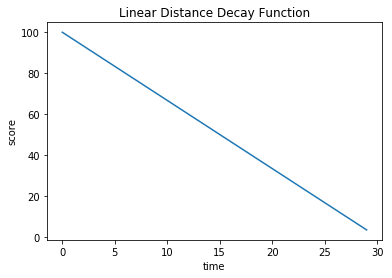

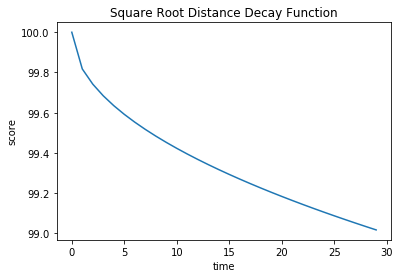

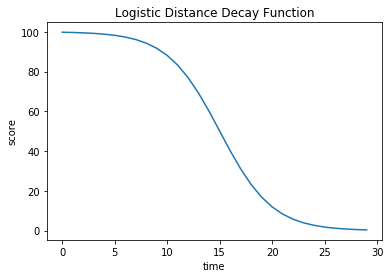

In [9]:
%matplotlib inline

#plots with upper=30
plt.xlabel('time')
plt.ylabel('score')
plt.title("Linear Distance Decay Function")
graph('(-30*.1111)*x +100', range(0, 30))

plt.xlabel('time')
plt.ylabel('score')
plt.title("Square Root Distance Decay Function")
graph('(1 / math.sqrt(30) ) * (-x ** 0.5) + 100', range(0, 30))

plt.xlabel('time')
plt.ylabel('score')
plt.title("Logistic Distance Decay Function")
graph('100-(100/(np.exp(6-.4*x)+1))', range(0, 30))


<span style="color:red"> **Open the following code to define the different _score weights_, type of _aggregation_ and _binning_, if needed.**

- **Type of weights:** 
    - **distance_weight:** Distance decay function (linear, square root or logit) defined above.  
    - **diminish_cat_weight :** Number of times a category is present within the area of analysis. The establishment will have a weight of 1 if it's present once; a weight of 0.75 if it's present twice, ... (according to **DIMINISH_WEIGHTS = [0.1, 0.25, 0.5, 0.75, 1.0]**). These values can be changed depending on how much the user wants to weight multiple establishments of the same category within each unit of analysis. 
    - **variety_weight:** The score also consideres the variety of categories within the area of analysis. The variety of categories is valued by a function which is defined under **diminish_variety_weight**. The default is the diminishing function of **log(5 * n) + 1**, where a greater variety of establishment types per area of analysis gets a greater score value.  
    
    Any weight can be omitted/added on the line that specifies the total score: Delete the diminish_cat_weighht in the line below if you do not want to tyake into account the diminishing weights.  
    score += (diminish_cat_weight) x (distance_weight) x (variety_weight)

  
- **Type of aggregation:** The default aggregates scores by population and by community area. However, the score can be aggregated differently under **custom_threshold_percent** and **custom_threshold_pop**.  

    
- **Binning:** The preset code defines 3 bins: Scores from [0,50), [50, 70), and [70, 100]. Again, the user can change the binning in **custom_threshold**. 

The **average speeds** can be specified within the p2p_parameters.json file located in the contracts>analytics folder (5 km/hr for walking and 25 km/hr for driving).

In [ ]:
# Define HSSA Access Score Model 

class HSSAModel(ModelData):
    '''
    Build the HSSA model which captures the accessibility of 
    nonprofit services in urban environments.
    '''

    def __init__(self, network_type='drive', source_filename=None, 
        dest_filename=None, sp_matrix_filename=None, decay_function='linear',
        limit_categories=None, upper=30):

        super().__init__(network_type, upper)
        self.results = None

        if decay_function == 'linear':
            self.decay_function = linear_decay_function
        elif decay_function == 'root':
            self.decay_function = root_decay_function
        elif decay_function == 'logit':
            self.decay_function = logit_decay_function
        else:
            self.logger.error('Unrecognized decay function. Must be one of: linear, root or logit')

        self.load_sources(source_filename)
        self.load_dests(dest_filename)
        self.load_sp_matrix(sp_matrix_filename)
        self.process()
        self.limit_categories = limit_categories
        assert type(limit_categories) == type(set()) or limit_categories == None, 'limit_categories must be of type set or None'

        self.good_to_write = False
        self.custom_threshold = None


    def diminish_variety_weight(self, n):
        '''
        Log increasing function to weight blocks with access
        to more varieties of categories more heavily.
        Inputs:
            n- integer
        Returns: float
        '''
        if n == 0:
            return 0
        else:
            return math.log(5 * n) + 1


    def calculate(self, custom_threshold=40, normalize=True, 
        use_target=False, custom_weight_dict=None, largest_weights_first=True):
        '''
        Calculate the HSSA score for each block
        from the vendors within the specified range.
        Inputs:
            custom_threshold- integer or float, optional. Results will contain
            a column showing percent of population with score greater
            than or equal to this value
            normalize-Boolean, optional (defaults to true). If true,
            final scores will be normalized on a range from 0-100.
            use_target-Boolean, defaults to false. If true, use the target value
            in the final score.
            custom_weight_dict-a dictionary mapping strings of category names
            to a list of integer or float weights
            largest_weights_first: boolean, if using custom_weight_dict. If True,
            sort the weight arrays such that largest will be used first. IF false,
            do the opposite.
        '''
        start_time = time.time()
        self.custom_threshold = custom_threshold
        #subset the destination data frames on limit_categories


        if self.limit_categories:
            normalized_targets = self.dests[self.dests['category'].isin(self.limit_categories)].copy(deep=True)
        else:
            normalized_targets = self.dests.copy(deep=True)

        if use_target:
            #first, find per capita spending for each destination
            normalized_targets['pc_target'] = 0
            for dest_id, source_list in self.dest2source.items():
                service_population = 0
                if dest_id not in normalized_targets.index:
                    continue
                #sum up the service population in range of each destination
                for item in source_list:
                    source_id, time_val = item
                    source_population = self.get_population(source_id)
                    if np.isnan(source_population):
                        continue

                    #account for the sources with negative (aka error) values
                    if source_population > 0:
                        service_population += source_population

                if service_population > 0:
                    pc_target = normalized_targets.loc[dest_id, 'target'] / service_population
                else:
                    pc_target = 0


                normalized_targets.loc[dest_id, 'pc_target'] = pc_target


            all_contracts = list(normalized_targets['pc_target'])
        
            #grab some statistics
            sd = np.nanstd(all_contracts)
            mean = np.nanmean(all_contracts)

            #normalize the target amount
            normalized_targets['pc_target'] = (normalized_targets['pc_target'] - mean) / sd

            #set minimum to zero
            min_amt = normalized_targets['pc_target'].min()
            normalized_targets['pc_target'] += (abs(min_amt) + 1)
            self.normalized_targets = normalized_targets
        
        DIMINISH_WEIGHTS = [.1, .25, .5, .75, 1]
        results = {}
        itemized_results = {}


        #sort the user's input arrays, such that the highest
        #weight will be used first and the lowest weight will be
        #used last
        if custom_weight_dict is not None:
            for key in custom_weight_dict.keys():
                custom_weight_dict[key].sort(reverse=not largest_weights_first)

        for source_id, dest_list in self.source2dest.items():
            if custom_weight_dict is not None:
                weight_dict = custom_weight_dict
            else:
                weight_dict = {}
            score = 0
            num_varieties = 0
            #print(weight_dict)

            for item in dest_list:
                dest_id, time_val = item
                cat = self.get_category(dest_id)

                #skip this dest if not in limit categories
                if self.limit_categories != None and cat not in self.limit_categories:
                	continue

                #if we haven't encountered this category for this source,
                #create a new list of weights
                if cat not in weight_dict.keys():
                    weight_dict[cat] = DIMINISH_WEIGHTS[:]
                    num_varieties += 1
                print(weight_dict[cat])

                #if we have encountered this category for this source,
                #take the next highest weight (0 if all weights have)
                #already been used
                if len(weight_dict[cat]) > 0:
                    diminish_cat_weight = weight_dict[cat].pop()
                else:
                    diminish_cat_weight = 0
                print(diminish_cat_weight)
                distance_weight = self.decay_function(time_val, self.upper)
                variety_weight = self.diminish_variety_weight(num_varieties)
                
                #combine all the elements
                if use_target:
                    target_amount = normalized_targets.loc[dest_id, 'pc_target']
                    score += diminish_cat_weight * distance_weight * target_amount * variety_weight
                else:
                    score += diminish_cat_weight * distance_weight
                


            results[source_id] = score

    
        #convert to DataFrame
        res = pd.DataFrame.from_dict(results, orient='index')
        res.rename(columns={ res.columns[0]: "score" }, inplace=True)

        #join with source data
        self.results = self.sources.join(res)

        #drop rows with no target population
        self.results = self.results[self.results['population'] > 0]


        #normalize scores to range (0, 100) and make sure set is not empty
        #and create the population weighted score
        self.results['pop_weighted_score'] = self.results['score'] * self.results['population']
        if normalize:
            C = self.results['score'].max() / 100
            self.results['score_sd'] = self.results['score'] / C

            C = self.results['pop_weighted_score'].max() / 100
            self.results['pop_weighted_score'] = self.results['pop_weighted_score'] / C

        

        #bin the population according to their access
        self.results.loc[self.results['population'] < 0, 'population'] = 0
        self.results['0_50'] = self.results['population'][self.results['score'] < 50]
        self.results['50_70'] = self.results['population'][(self.results['score'] >= 50) & (self.results['score'] < 70)]
        self.results['70_100'] = self.results['population'][self.results['score'] >= 70]
        self.results['custom_threshold_pop'] = self.results['population'][self.results['score'] >= self.custom_threshold]


        self.results.fillna(0, inplace=True)
        self.good_to_write = True
        self.logger.info("Finished calculating hssa in {:,.2f} seconds".format(time.time() - start_time))

    def write_csv(self, filename=None):
        '''
        Write the model data to file.
        '''
        assert self.good_to_write, 'need to calculate first'
        if not filename:
            filename = self.get_output_filename('HSSA_{}'.format(self.network_type))
        self.results.to_csv(filename)


    def _get_aggregate(self, aggregate_type):
        '''
        Build an data frame of the results aggregated
        by community.
        Inputs
            aggregate_type: can be either 'score' or
            'population'. If the former, the aggregation
            performed is average. If the latter, the
            aggregation is summation.
        '''
        assert self.good_to_write, 'need to calculate first'

        coms = set(self.sources['community'])
        com_geometry = {}
        for data in self.results.itertuples():
            if (len(coms) == 0):
                break
            elif data[1] in coms:
                com_geometry[data[1]] = data[5]
                coms.remove(data[1])

        com_geoareas = pd.DataFrame.from_dict(com_geometry, orient='index')
        com_geoareas.rename(columns={ 0: "geometry" }, inplace=True)

        if aggregate_type == 'population':
            res = self.results.groupby(['community']).sum()
            #res = res[['population','0_50','50_70','70_100','custom_threshold_pop']]
            res['custom_print(threshold_percent'] = res['custom_threshold_pop'] / res['population']
        elif aggregate_type == 'score': 
            res = self.results.groupby(['community']).mean()
            res = res[['pop_weighted_score', 'score']]
        else:
            self.logger.error('Unknown aggregate_type: ({})'.format(aggregate_type))
            return None
        return res.join(com_geoareas)

    def get_aggregate(self, aggregate_type):
        '''
        Strip the aggregated data frame of misleading
        data before giving it to the end user
        '''

        res = self._get_aggregate(aggregate_type)
        if res is not None:
            return res.drop(['geometry'],axis=1)
        else:
            return None
        


    def write_aggregate(self, aggregate_type, filename=None):
        '''
        Write the aggregate to csv
        '''
        df = self.get_aggregate(aggregate_type)
        if not filename:
            filename = self.get_output_filename('HSSA_{}_aggregate'.format(aggregate_type))

        df.to_csv(filename)
        self.logger.info('Wrote aggregate to file: {}'.format(filename))


    def plot_aggregate(self, plot_type='score', include_vendors=True):
        '''
        Genereate a choropleth at the community area resolution.
        Inputs
            plot_type: 'score', 'population' or 'custom_threshold_percent'
            include_vendors: overlay a scatterplot of the vendors. Target
                value corresponds to dot size. Vendors of different
                categories are uniquely colored.
        '''
        assert self.good_to_write, "must calculate first"
        mpl.pyplot.close()
        fig_name = self.figure_name()
        mpl.pyplot.rcParams['axes.facecolor'] = '#cfcfd1'
        crs = {'init': 'epsg:4326'}
        if plot_type == 'score':
            title = 'Aggregated HSSA Score'
            color_map = 'Blues'
            grouped_results = self._get_aggregate('score')
            gdf = GeoDataFrame(grouped_results['pop_weighted_score'], crs=crs, 
                geometry=grouped_results['geometry'])
            plot_type = 'pop_weighted_score'
        elif plot_type == 'population':
            title = 'Low Income Population'
            color_map = 'Purples'
            grouped_population = self._get_aggregate('population')
            gdf = GeoDataFrame(grouped_population['population'], 
                crs=crs, geometry=grouped_population['geometry'])
        elif plot_type == 'custom_threshold_percent':
            title = 'Percent of population with HSSA score above {}'.format(self.custom_threshold)
            color_map = 'Oranges'
            grouped_population = self._get_aggregate('population')
            gdf = GeoDataFrame(grouped_population['custom_threshold_percent'], 
                crs=crs, geometry=grouped_population['geometry'])
        else:
            self.logger.error("Unknown aggregate type. Try 'score', 'population' or 'custom_threshold_percent'")
            return

        gdf.plot(column=plot_type,cmap=color_map, edgecolor='grey')

        #add a scatter plot of the vendors over the chloropleth

        if include_vendors:
            available_colors = ['magenta','lime','red','black','orange','grey','yellow','brown','teal']
        
            #if we have too many categories of vendors, limit to using black dots
            if len(self.cat2dests) > len(available_colors):
                monochrome = True
            else:
                monochrome = False
            color_keys = []
            max_dest_target = max(self.dests['target'])
            for cat in self.cat2dests:
                if self.limit_categories:
                    if cat not in self.limit_categories:
                        continue
                if monochrome:
                    color = 'black'
                else:
                    color = available_colors.pop(0)
                    patch = mpatches.Patch(color=color, label=cat)
                    color_keys.append(patch)
                dest_subset = self.dests.loc[self.dests['category'] == cat]
                mpl.pyplot.scatter(y=dest_subset['lat'],x=dest_subset['lon'],color=color, marker='o', 
                    s=50 * (dest_subset['target'] / max_dest_target), label=cat)
                if not monochrome:
                    mpl.pyplot.legend(loc='best', handles=color_keys)

        mpl.pyplot.title(title)
        mpl.pyplot.savefig(fig_name, dpi=400)
        mpl.pyplot.show()
        self.logger.info('Plot was saved to: {}'.format(fig_name))
        return

    def plot_cdf(self, title='Hyde Park, Woodlawn and Kenwood'):
        '''
        Generate a CDF of the aggregate HSSA score.
        Inputs
            title: the title of the figure
        '''
        assert self.good_to_write, "must calculate first"
        mpl.pyplot.rcParams['axes.facecolor'] = '#cfcfd1'
        x = self.results.loc[self.results['population'] > 0]['score']
       
        mpl.pyplot.close()
        fig, ax = mpl.pyplot.subplots(figsize=(8, 4))
        n_bins = 100
        n, bins, patches = ax.hist(x, n_bins, density=True, histtype='step',
                           cumulative=True, label='All Categories of Spending')

        ax.grid(True)
        ax.legend(loc='right')
        ax.set_title(title)
        ax.set_xlabel('HSSA Score')
        ax.set_ylabel('Percent of Blocks by Value')
        fig_name = self.figure_name()
        mpl.pyplot.savefig(fig_name, dpi=400)
        mpl.pyplot.show()
        self.logger.info('Plot was saved to: {}'.format(fig_name))

        return


In [67]:
# Define Per Capita Access Score Model 
class PCSpendModel(ModelData):
    '''
    Build the Per capita spending model which captures
    the level of spending for low income residents in
    urban enviroments.
    '''

    def __init__(self, network_type='drive', source_filename=None, 
        dest_filename=None, sp_matrix_filename=None, limit_categories=None,
        upper=30):

        super().__init__(network_type, upper)
        self.results = None
        self.limit_categories = limit_categories
        self.results_initialized = False
        assert type(limit_categories) == type(set()) or limit_categories == None, 'limit_categories must be of type set or None'

        self.load_sources(source_filename)
        self.load_dests(dest_filename)
        self.load_sp_matrix(sp_matrix_filename)
        self.process()

        self.good_to_write = False

    def calculate(self):
        '''
        Calculate the per capita value of ALL categories
        in the limited categories set, or the composite value
        for all categories.
        '''
        start_time = time.time()
        first = True
        #sum each limited catagory separately
        if self.limit_categories:
            for category in self.limit_categories:
                self.calculate_single(category)
                #combine each category of spending to one total value
                if first:
                    self.results['all_categories'] = 0
                    first = False
                self.results['all_categories'] += self.results[category]
        else:
            #sum all categories together
            self.calculate_single(None)

        #drop rows with no target population
        self.results = self.results[self.results['population'] > 0]

        self.good_to_write = True
        self.logger.info("Finished calculating pcspend in {:,.2f} seconds".format(time.time() - start_time))

    def calculate_single(self, subset):
        '''
        Calculate the per capita value of ONE category
        in the limited categories set, or the composite value
        for all categories.
        Inputs:
            subset: 'all_categories', or the name of a single
                category
        '''

        #find each dest's target value per capita
        dest_percap_target = {}
        if subset:
            subset_name = subset
        else:
            subset_name = 'all_categories'

        for dest_id, source_list in self.dest2source.items():
            if subset:
                if self.get_category(dest_id) != subset:
                    continue
            serv_pop = 0
            for item in source_list:
                source_id, time_val = item
                source_pop = self.get_population(source_id)
                if source_pop > 0:
                    serv_pop += source_pop
            dest_target = self.get_target(dest_id)
            if serv_pop > 0:
                dest_percap_target[dest_id] = dest_target / serv_pop
            else:
                dest_percap_target[dest_id] = 0



        #allocate each vendor's per capita spending to blocks in range 
        rv = {}
        for source_id, dest_list in self.source2dest.items():
            if self.get_population(source_id) <= 0:
                continue
            running_total = 0
            for item in dest_list:
                dest_id, time_val = item
                if subset:
                    if self.get_category(dest_id) != subset:
                        continue
                running_total += dest_percap_target[dest_id]
            rv[source_id] = running_total

        #convert to DataFrame
        
        res = pd.DataFrame.from_dict(rv, orient='index')
        if len(res) == 0:
            return
        res.rename(columns={ res.columns[0]: subset_name }, inplace=True)

        if not self.results_initialized:
            self.results = self.sources.join(res)
            self.results_initialized = True
        else:
            self.results[subset_name] = res[subset_name]

        self.results.fillna(0, inplace=True)


    def _get_aggregate(self, aggregate_type):
        '''
        Build an data frame of the results aggregated
        by community.
        Inputs
            aggregate_type: can be either 'pcspend' or
            'population'. If the former, the aggregation
            performed is average. If the latter, the
            aggregation is summation.
        '''
        assert self.good_to_write, 'need to calculate first'

        coms = set(self.sources['community'])
        com_geometry = {}
        for data in self.results.itertuples():
            if (len(coms) == 0):
                break
            elif data[1] in coms:
                com_geometry[data[1]] = data[5]
                coms.remove(data[1])

        com_geoareas = pd.DataFrame.from_dict(com_geometry, orient='index')
        com_geoareas.rename(columns={ 0: "geometry" }, inplace=True)

        if aggregate_type == 'population':
            res = self.results.groupby(['community']).sum()
            res = res[['population']]
        elif aggregate_type == 'pcspend':
            res = self.results.groupby(['community']).mean()
            res = res[['all_categories']]
        else:
            self.logger.error('Unknown aggregate_type: ({})'.format(aggregate_type))
            return None
        res = res.join(com_geoareas)

        return res

    def get_aggregate(self, aggregate_type):
        '''
        Strip the aggregated data frame of misleading
        data before giving it to the end user
        '''

        res = self._get_aggregate(aggregate_type)
        if res is not None:
            return res.drop(['geometry'],axis=1)
        else:
            return None
 

    def write_aggregate(self, aggregate_type, filename=None):
        '''
        Write the aggregate to csv
        '''
        df = self._get_aggregate(aggregate_type)
        if not filename:
            filename = self.get_output_filename('pcspend_{}_aggregate'.format(aggregate_type))

        df.to_csv(filename)
        self.logger.info('Wrote aggregate to file: {}'.format(filename))


    def plot_aggregate(self, plot_type='pcspend', include_vendors=True, 
        focus_column='all_categories'):
        '''
        Genereate a choropleth at the community area resolution.
        Inputs
            plot_type: 'pcspend' or 'population'
            include_vendors: overlay a scatterplot of the vendors. Target
                value corresponds to dot size. Vendors of different
                categories are uniquely colored.
            focus_column: if the model has limit_categories, specify
                the specific category of vendor
        '''
        #aggregate by community area
        assert self.good_to_write, "must calculate first"
        if self.limit_categories and plot_type == 'pcspend':
            assert focus_column in self.limit_categories, "focus_column must be in the set of limited categories"

        coms = set(self.sources['community'])
        com_geometry = {}
        for data in self.results.itertuples():
            if (len(coms) == 0):
                break
            elif data[1] in coms:
                com_geometry[data[1]] = data[5]
                coms.remove(data[1])

        com_geoareas = pd.DataFrame.from_dict(com_geometry, orient='index')
        com_geoareas.rename(columns={ 0: "geometry" }, inplace=True)


        mpl.pyplot.close()
        fig_name = self.figure_name()
        mpl.pyplot.rcParams['axes.facecolor'] = '#cfcfd1'
        crs = {'init': 'epsg:4326'}
        if plot_type == 'pcspend':
            title = 'Aggregated Per Capita Spending'
            color_map = 'Greens'
            grouped_results = self.get_aggregate('pcspend')
            gdf = GeoDataFrame(grouped_results, crs=crs, geometry=grouped_results['geometry'])
        elif plot_type == 'population':
            title = 'Low Income Population'
            color_map = 'Purples'
            grouped_population = self.get_aggregate('population')
            gdf = GeoDataFrame(grouped_population, crs=crs, geometry=grouped_population['geometry'])
            focus_column = 'population'
        else:
            self.logger.error("Unknown aggregate type. Try 'pcspend' or 'population'")
            return

        gdf.plot(column=focus_column,cmap=color_map, edgecolor='grey')

        #add a scatter plot of the vendors over the chloropleth
        if include_vendors:
            available_colors = ['magenta','lime','red','black','orange','grey','yellow','brown','teal']
            #if we have too many categories of vendors, limit to using black dots
            if len(self.cat2dests) > len(available_colors):
                monochrome = True
            else:
                monochrome = False
            color_keys = []
            max_dest_target = max(self.dests['target'])
            for cat in self.cat2dests:
                if self.limit_categories:
                    if cat not in self.limit_categories:
                        continue
                if monochrome:
                    color = 'black'
                else:
                    color = available_colors.pop(0)
                    patch = mpatches.Patch(color=color, label=cat)
                    color_keys.append(patch)
                dest_subset = self.dests.loc[self.dests['category'] == cat]
                mpl.pyplot.scatter(y=dest_subset['lat'],x=dest_subset['lon'],color=color, marker='o', 
                    s=50 * (dest_subset['target'] / max_dest_target), label=cat)
                if not monochrome:
                    mpl.pyplot.legend(loc='best', handles=color_keys)

        mpl.pyplot.title(title)
        mpl.pyplot.savefig(fig_name, dpi=400)
        mpl.pyplot.show()
        self.logger.info('Plot was saved to: {}'.format(fig_name))
        return

    def plot_cdf(self, title='Per Capita Spending'):
        '''
        Generate a CDF. If limit_categories was specified,
        each category will be given individually. If not, the
        aggregate value will be plotted.
        Inputs
            title: the title of the figure
        '''

        assert self.good_to_write, "must calculate first"

        #blocks with population greater than zero
        cdf_eligible = self.results.loc[self.results['population'] > 0]
        
        #initialize block parameters
        mpl.pyplot.close()
        mpl.pyplot.rcParams['axes.facecolor'] = '#cfcfd1'
        fig, ax = mpl.pyplot.subplots(figsize=(8, 4))
        n_bins = 100

        available_colors = ['black','magenta','lime','red','black','orange','grey','yellow','brown','teal']
        color_keys = []
        if self.limit_categories:
            for category in self.limit_categories:
                x = cdf_eligible[category]
                color = available_colors.pop(0)
                patch = mpatches.Patch(color=color, label=category)
                color_keys.append(patch)
                n, bins, blah = ax.hist(x, n_bins, density=True, histtype='step',
                    cumulative=True, label=category, color=color)
        else:
            x = cdf_eligible['all_categories']
            n, bins, patches = ax.hist(x, n_bins, density=True, histtype='step',
                cumulative=True, label='all_categories')

        if self.limit_categories:
            ax.legend(loc='right',handles=color_keys)
        else:
            ax.legend(loc='right')
        ax.grid(True)
        ax.set_title(title)
        ax.set_xlabel('Per Capita Spending ($)')
        ax.set_ylabel('Percent of Blocks by Value')
        fig_name = self.figure_name()
        mpl.pyplot.savefig(fig_name, dpi=400)
        mpl.pyplot.show()
        self.logger.info('Plot was saved to: {}'.format(fig_name))

        return


    def write_csv(self, filename=None):
        '''
        Write the model data to file.
        '''
        assert self.good_to_write, 'need to calculate first'
        if not filename:
            filename = self.get_output_filename('PCSpend_{}'.format(self.network_type))
        self.results.to_csv(filename)


<a id='distance'></a>

--- 
<h1><center>DEMO</center></h1>  


**View structure of data example: Health Facilities in Chicago.**  
Health Facilities Data: http://makosak.github.io/chihealthaccess/index.html

In [97]:
df = pd.read_csv('resources/marynia_health.csv')
df.head()

,agency_id,facility,lat,lon,cat_num,target,category
0,1,"American Indian Health Service of Chicago, Inc.",41.956676,-87.651879,5,1000,Other Health Providers
1,2,Hamdard Center for Health and Human Services,41.997852,-87.669535,5,2000,Other Health Providers
2,3,Infant Welfare Society of Chicago,41.924904,-87.717270,5,1000,Other Health Providers
3,4,Mercy Family - Henry Booth House Family Health...,41.841694,-87.624790,5,3000,Other Health Providers
4,6,Cook County - Dr. Jorge Prieto Health Center,41.847143,-87.724975,5,1500,Other Health Providers


### Distance Matrices  

<span style="color:LimeGreen"> **Specifications for the symmetric and asymmetric distance matrices:**  

- network_type (drive or walk)
- epsilon=0.05 (can change default)  
- primary_input  
- secondary_input  
- output_type='csv'  
- n_best_matches=4 (for simulations)
- read_from_file=None  
- write_to_file (set as True if user wants to save results)   
- load_to_mem=True (True is default but can set it to False if the user is running a computational intensive process >>>.)

**Please make sure latitude and longitude are correct if using X and Y.**

#### Model 1: Symmetric Matrix 
---
The first model creates a symmetric distance travel matrix from block to block (46,357 x 46,367 matrix). Then, we snap the destination points to the area of analysis (blocks), getting a matrix that calculates the distance between the destinations and every block in the dataset. 
**** There are 46,357 blocks in the city of Chicago, but are reduced to 46,265 so it matches to the community level aggregation.  
Nevertheless, we need to obtain the distance matrix first (takes approx. 15 min):

In [ ]:
# Specify walking distance matrix (takes ~30 min to run) 
w_sym_mat = TransitMatrix(network_type='walk',
                          primary_input='resources/LEHD_blocks.csv',
                          write_to_file=True,
                          load_to_mem=True)

# Run process
w_sym_mat.process()

# Saved as w_sym_mat.csv

In [ ]:
# Specify driving distance matrix (takes ~30 minutes to run) 
d_sym_mat = TransitMatrix(network_type='drive',
                          primary_input='resources/LEHD_blocks.csv',
                          write_to_file=True,
                          load_to_mem=True)

# Run process. For driving, p2p queries OSM to fetch the street network and then output the shortest path transit matrix
d_sym_mat.process(speed_limit_filename='resources/condensed_street_data.csv')

# Saved as d_sym_mat.csv

Now, snap the points to the units of analysis. However, snapping the destination points is not always so straightforward. Deciding which points (laying on the network) are assigned to each area of analysis may be arbitrary; therefore, it is important to scrutinize the structure of the data before doing any further processing. If the destinations fall within the unit of analysis, the best option is to run a within function that incorporates the destinations to the unit of analysis and then doing a join with the area IDs.
The following image shows that in this case, we can safely run a function that assigns each point to the area of analysis of interest. 

<img src="resources/img2.png" width="500" title="Optional title">

**Spatial join of health facilities and area of analysis**

Finally, in order to get the matrix of origins to destinations, we need to join the health facilities by block with the distance matrix previously generated. This will generate an asymmetric matrix with all the distances from destinations to all the units of analysis in Chicago.

In [ ]:
# Read destination files to join with boundaries 
health_gdf = gpd.read_file('resources/marynia_health.shp')
health_gdf.head()
#Use symmetric matrix calculated above or read your previously saved results:
#sym_walk=pd.read_csv('data/walk_sym.csv')

# Read boundaries files 
boundaries_gdf = gpd.read_file('resources/blocks_46265.shp')

# Rename the ID name in order to match both data frames. 
sym_walk= sym_walk.rename(index=str, columns={"Unnamed: 0": "geoid10"})

# Spatial join of amenities within each area of analysis 
s_join = gpd.sjoin(health_gdf, boundaries_gdf, how='inner', op='within')

# Convert geopanda dataframe to non-spatial dataframe to join 
jb_df = pd.DataFrame(s_join)

# Make sure the id is of the same data type in both data frames.
# sym_walk.dtypes
# jb_df.dtypes
jb_df.geoid10=jb_df.geoid10.astype(int)

# Join the symmetric matrix with the spatially joined data (with geoid10 id)
j_asym=pd.merge(sym_walk, jb_df, left_on='geoid10', right_on='geoid10', how='inner')

In [ ]:
# Check that the spatial join and join ran appropriately 
j_asym.head()

## Model 2: Asymmetric Matrix  
---
The second model directly creates an asymmetric matrix from destination points to the centroids of the area of analysis (also takes ~ 20 min). This approach is most effective when you are only calculating the distance matrix or a particular distance score once.

In [ ]:
# Calculate asymmetric distance matrix for walking 

w_asym_mat = TransitMatrix(network_type='walk',
                           primary_input='resources/LEHD_blocks.csv',
                           secondary_input='resources/marynia_health.csv', 
                           write_to_file=True)

w_asym_mat.process()

#The output is walk_asym_health.csv (used in the calculation of the access scores)

In [ ]:
# Calculate asymmetric distance matrix for driving 

d_asym_mat = TransitMatrix(network_type='drive',
                           primary_input='resources/LEHD_blocks.csv',
                           secondary_input='resources/nets_all.csv',
                           write_to_file=True)

d_asym_mat.process(speed_limit_filename='resources/condensed_street_data.csv')

#The output is drive_asym_health.csv (used in the calculation of the access scores)

In [ ]:
# Calculate asymmetric distance matrix for driving (Currently not working)

b_asym_mat = TransitMatrix(network_type='bike',
                           primary_input='resources/LEHD_blocks.csv',
                           secondary_input='resources/marynia_health.csv',
                           write_to_file=True)

b_asym_mat.process()

#The output is bike_asym_health.csv (used in the calculation of the access scores)

<a id='scores'></a>

## Calculating the Access Score
---

<span style="color:LimeGreen"> **Specifications for the HSSA Model:**  

HSSAModel( ):  
- Network_type ('drive' or 'walk')
- source_filename
- dest_filename
- sp_matrix_filename (None implies that the user hasn't previously generated a distance matrix; thus, calculating it on the fly.)  
- decay_function ('linear', 'root', 'logit')
- limit_categories (None is defined as default, but user can delimit on particular categories of interest.)  
- upper=30 (can change default) is the time (in minutes) in which the origin and destinations are considered to be out of range of each other. Thus, if the travel time distance exceeds 30 minutes, the score will be zero.
- custom_threshold=40 (change binning threshold specifying it in calculate() function. Example: model_name.calculate(custom_threshold=40)

Spatial areal units with no population are denominated as NA (>>> WRONG - CHANGE after Logan fixes) while spatial areal units beyond the 30 minute buffer are denominated as zeros.

In **model_name.calculate( )** specify the following parameters:  
* normalize=True (if want standarized and unstandarizes score outputs)
* use_target=False (neglect target as a weight) >>> will be deprecated soon
* custom_weight_dict=None (set dictionary of weights if user has specific loadings of interest)  
* largest_weights_first=True (set dictionary or default weights as the largest ones first)

Dictionary weights should be set as the following example:  
my_dict = {'Hospitals' : [200, 300,299, 250],  
                'Federally Qualified Health Centers ' : [60,70,70,80,90,100],  
                'School-Based Health Centers': [40,20,10],  
                'All Free Health Clinics': [100,20,1,5]}

**Different distance decay functions**

In [ ]:
# Linear access score (walking) 
HSSA_wlinear = HSSAModel(network_type='walk',
                    source_filename='resources/LEHD_blocks.csv',
                    dest_filename='resources/marynia_health.csv',
                    sp_matrix_filename='data/walk_asym_health.csv',
                    decay_function='linear',
                    limit_categories=None,
                    upper=30)

In [ ]:
HSSA_wlinear.calculate((normalize=True, use_target=False, custom_weight_dict=None, largest_weights_first=False))
HSSA_wlinear.write_csv()

In [ ]:
# Linear access score (driving) 
HSSA_dlinear = HSSAModel(network_type='drive',
                    source_filename='resources/LEHD_blocks.csv',
                    dest_filename='resources/marynia_health.csv',
                    sp_matrix_filename='data/drive_asym_health.csv',
                    decay_function='linear',
                    limit_categories=None,
                    upper=30)

In [ ]:
HSSA_dlinear.calculate((normalize=True, use_target=False, custom_weight_dict=None, largest_weights_first=False))
HSSA_dlinear.write_csv()

In [ ]:
# Square root access score (walking) 
HSSA_wroot = HSSAModel(network_type='walk',
                    source_filename='resources/LEHD_blocks.csv',
                    dest_filename='resources/marynia_health.csv',
                    sp_matrix_filename='data/walk_asym_health.csv',
                    decay_function='root',
                    limit_categories=None,
                    upper=30)


In [ ]:
HSSA_wroot.calculate((normalize=True, use_target=False, custom_weight_dict=None, largest_weights_first=False))
HSSA_wroot.write_csv()

In [ ]:
# Square root access score (driving) 
HSSA_droot = HSSAModel(network_type='drive',
                    source_filename='resources/LEHD_blocks.csv',
                    dest_filename='resources/marynia_health.csv',
                    sp_matrix_filename='data/drive_asym_health.csv',
                    decay_function='root',
                    limit_categories=None,
                    upper=30)
HSSA_droot.calculate()
HSSA_droot.write_csv()

In [ ]:
# Logit access score (walking) 
HSSA_wlogit = HSSAModel(network_type='walk',
                    source_filename='resources/LEHD_blocks.csv',
                    dest_filename='resources/marynia_health.csv',
                    sp_matrix_filename='data/walk_asym_health.csv',
                    decay_function='logit',
                    limit_categories=None,
                    upper=30)


In [ ]:
HSSA_wlogit.calculate(normalize=True, use_target=False, custom_weight_dict=None, largest_weights_first=False)
HSSA_wlogit.write_csv()

In [ ]:
# Logit access score (driving) 
HSSA_dlogit = HSSAModel(network_type='drive',
                    source_filename='resources/LEHD_blocks.csv',
                    dest_filename='resources/marynia_health.csv',
                    sp_matrix_filename='data/drive_asym_health.csv',
                    decay_function='logit',
                    limit_categories=None,
                    upper=30)


In [ ]:
HSSA_dlogit.calculate()
HSSA_dlogit.write_csv()

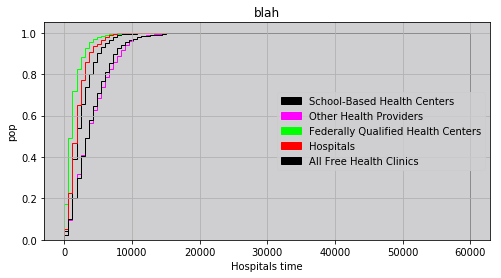

INFO:__main__:Plot was saved to: blah


In [95]:
#Create cdf for nearest neighbor travel time distance measure
HSSA_wlogit.nearest_cat_for_source.plot_cdf(xlabel='Time to facilities',
               ylabel='Population'
               title='Empirical Cumulative Distribution of Health Facilities',
               fig_name='cdf_pop_time')

<img src="resources/stdev.png" width="500" title="Optional title"> 
<h3 align="center">Standard Deviation Maps of Different Distance Decay Functions</h3>

<img src="resources/boxplots.png" width="500" title="Optional title">
<h3 align="center">Boxplots of Different Distance Decay Functions</h3>

---
**By categories - subsetting**

In [87]:
#For Federally Qualified Health Centers (walking)
HSSAw1_30 = HSSAModel(network_type='walk',
                     source_filename='resources/LEHD_blocks.csv',
                     dest_filename='resources/marynia_health.csv',
                     sp_matrix_filename='data/walk_asym_health.csv',
                     decay_function='logit',
                     limit_categories=set(['Federally Qualified Health Centers']))
                      
HSSAw1_30.calculate()
HSSAw1_30.write_csv()

The variables in your data set are:
>  Unnamed: 0
>  BLOCKID10
>  POP10
>  CE01_2014
>  long
>  lat
Enter the unique index variable: BLOCKID10
Enter the population variable: POP10
Enter the latitude variable: lat
Enter the longitude variable: long
The variables in your data set are:
>  agency_id
>  facility
>  lat
>  lon
>  cat_num
>  target
>  category
Enter the unique index variable: agency_id
Enter the target variable: target
Enter the category variable: category
Enter the latitude variable: lat
Enter the longitude variable: lon


INFO:__main__:Loading data from file: data/walk_asym_health.csv
INFO:__main__:Shortest path matrix loaded from disk in 1.01 seconds
INFO:__main__:Loaded sp matrix from file: data/walk_asym_health.csv
INFO:__main__:Processing... This could take a while
INFO:__main__:Finished processing ModelData in 33.97 seconds
INFO:__main__:Finished calculating hssa in 10.36 seconds


In [ ]:
#For Hospitals (walking) 
HSSAw2_30 = HSSAModel(network_type='walk',
                     source_filename='resources/LEHD_blocks.csv',
                     dest_filename='resources/marynia_health.csv',
                     sp_matrix_filename='data/walk_asym_health.csv',
                     decay_function='root',
                     limit_categories=set(['Hospitals']))
                      
HSSAw2_30.calculate()
HSSAw2_30.write_csv()

In [ ]:
#For All Free Health Clinics (walking) 
HSSAw3_30 = HSSAModel(network_type='walk',
                     source_filename='resources/LEHD_blocks.csv',
                     dest_filename='resources/marynia_health.csv',
                     sp_matrix_filename='data/walk_asym_health.csv',
                     decay_function='root',
                     limit_categories=set(['All Free Health Clinics']))
                      
HSSAw3_30.calculate()
HSSAw3_30.write_csv()

In [ ]:
#For School-Based Health Centers (walking) 
HSSAw4_30 = HSSAModel(network_type='walk',
                     source_filename='resources/LEHD_blocks.csv',
                     dest_filename='resources/marynia_health.csv',
                     sp_matrix_filename='data/walk_asym_health.csv',
                     decay_function='root',
                     limit_categories=set(['School-Based Health Centers']))
                      
HSSAw4_30.calculate()
HSSAw4_30.write_csv()

In [ ]:
#For Other Health Providers (walking)  
HSSAw5_30 = HSSAModel(network_type='walk',
                     source_filename='resources/LEHD_blocks.csv',
                     dest_filename='resources/marynia_health.csv',
                     sp_matrix_filename='data/walk_asym_health.csv',
                     decay_function='root',
                     limit_categories=set(['Other Health Providers']))
                      
HSSAw5_30.calculate()
HSSAw5_30.write_csv()

---
**Aggregation**  

In the following step, we can aggregate to the community level by population or area of interest.
examples:  
modelname.get_aggregate('population') or model.get_aggregate('score')  

Write the aggregated results to a csv:  
write_aggregate(aggregate_type, filename=None)  

Generate choropleth  
modelname.plot_aggregate(plot_type='score', include_vendors=True)


Generate empircal cumulative distribution function (ECDF) 
modelname.plot_cdf()

Now, the file is joined with a shapefile of the city of Chicago (blocks_46265.shp  found in the resources folder), in order to have our data as a geodataframe and visualize the scores in a map:

In [ ]:
#error
HSSA_wlogit.get_aggregate('population') 

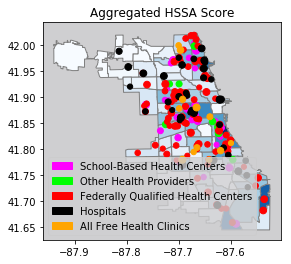

INFO:__main__:Plot was saved to: figures/fig_7.png


In [26]:
HSSA_wlogit.plot_aggregate()

#### Empirical Cumulative Distribution Function Plots

The following command 'plot_cdf' plotes an empiral cumulative distribution function.  

Example:  
AccessScoreModel.plot_cdf(title='specify title of the figure'):


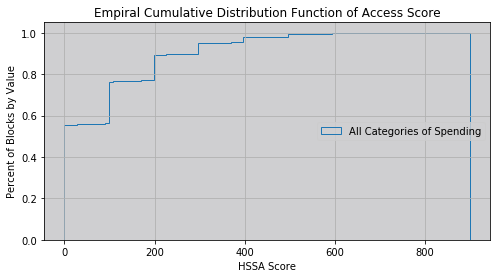

INFO:__main__:Plot was saved to: figures/fig_6.png


In [90]:
h2.plot_cdf(title='Empiral Cumulative Distribution Function of Access Score')

In [419]:
# Map the scores 
%matplotlib inline

#Copy of the model's results
wHSSA = HSSA_wl.results
#Create geometry

geometry = [Point(xy) for xy in zip(wHSSA['lon'], wHSSA['lat'])]
crs = {'init':'epsg:4326'}
geos = gpd.GeoDataFrame(wHSSA, crs=crs, geometry=geometry)

#Import the block level shapefile
boundaries_gdf = gpd.read_file('resources/blocks_46265.shp')

#Spatial join
geos = gpd.sjoin(boundaries_gdf, geos, how='inner', op='intersects')

In [420]:
geos.head()

,statefp10,countyfp10,tractce10,geoid10,blockce10,tract_bloc,name10,geometry,index_right,community,population,lat,lon,score,0_50,50_70,70_100,custom_threshold_pop
0,17,031,010100,170310101001000,1000,0101001000,Block 1000,POLYGON ((-87.66635499979151 42.02252199950325...,170310101001000,ROGERS PARK,128,42.022656,-87.666742,10.425141,128.0,0.0,0.0,128.0
1,17,031,010100,170310101001001,1001,0101001001,Block 1001,POLYGON ((-87.66753999955125 42.02223700032794...,170310101001001,ROGERS PARK,71,42.022604,-87.668811,10.427199,71.0,0.0,0.0,71.0
2,17,031,010100,170310101001002,1002,0101001002,Block 1002,POLYGON ((-87.67008600039445 42.02226200030603...,170310101001002,ROGERS PARK,45,42.021923,-87.668817,10.433806,45.0,0.0,0.0,45.0
3,17,031,010100,170310101001003,1003,0101001003,Block 1003,"POLYGON ((-87.67009499920478 42.0211490002601,...",170310101001003,ROGERS PARK,335,42.021476,-87.668374,10.434880,335.0,0.0,0.0,335.0
4,17,031,010100,170310101002000,2000,0101002000,Block 2000,POLYGON ((-87.67188399967968 42.02298600014132...,170310101002000,ROGERS PARK,152,42.022690,-87.670886,10.431845,152.0,0.0,0.0,152.0


#Plot the results of walking access score:
geos.plot(column='score')

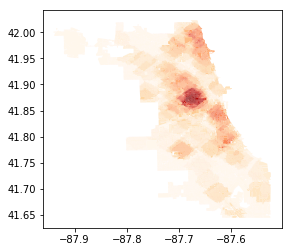

In [423]:
geos.plot(column='score', cmap='OrRd')

**Show Results** 

In [425]:
# Compare walking and driving standard deviation maps (add images)

<img src="resources/walk_img.png" width="500" title="Optional title"> 
<h3 align="center">Standard Deviation Map of Chicago Walk Access Scores for Health Facilities</h3>
<img src="resources/drive_img.png" width="500" title="Optional title"> <h3 align="center">Standard Deviation Map of Chicago Drive Access Scores for Health Facilities</h3>

Save results to desired projection

In [ ]:
geos.results['geometry'] = HSSA_aggregate.results.apply(lambda x: Point((float(x.lon), float(x.lat))), axis=1)
HSSA_comm=geopandas.GeoDataFrame(HSSA_aggregate.results, geometry='geometry’)
HSSA_comm.crs= "proj=utm +zone=16 +datum=WGS84 +units=m +no_defs"
HSSA_comm.to_file('data/HSSA_blocks.shp', driver='ESRI Shapefile')

## Calculating Nearest neighbor Travel Times by Category
---

In [ ]:
nn=HSSA_wlogit.nearest_cat_for_source

In [ ]:
nn.to_csv('data/nn.csv')

In [ ]:
plot_nearest_providers(limit_categories=None, 
                       title='Closest Point CDF by Block',
                       n_bins=500,
                       resolution='block')

In [ ]:
plot_nearest_providers(limit_categories=None,
                       title='Closest Point CDF by Population',
                       n_bins=500,
                       resolution='population')

## Calculating Count of Destinations by 30 Minute Buffer
---

In [ ]:
nd=HSSA_wlogit.n_dests_in_range

In [ ]:
nd.to_csv('data/nd.csv')

## Calculating the Per Capita Access Score
---


**Specifications for PCSpend Model:**  
PCSpendModel( ):  
- Network_type ('drive' or 'walk')
- source_filename  
- dest_filename
- sp_matrix_filename (None implies that the user hasn't previously generated a distance matrix; thus, calculating it on the fly.)  
- limit_categories (None is defined as default, but user can focus only on particular categories of interest.)  


Specifications:
- Target or amenity value (>>>where specify this? Should we still have the option to carry it out in the HSSA? Should we specify that there?): The establishment will be weighted depending of the size of the establishment. Size can be measured differently (in this case, it's the size of the health facility, but it could also be the number of patients it accomodates, etc.)   
- Category of interest

Functions within the PCSpend Model class (use as name_of_model.function()):  
- calculate () 
- calculate_single  (subset)
- get_aggregate (aggregate_type) Aggregation can be by ('population') or ('pcspend') score for the community level. If the user wants to modify the level of aggregation, change 'community' with other spatial unit of analysis in code.  
- write_aggregate (aggregate_type, filename='name')
- plot_aggregate  (plot_type='pcspend', include_vendors=True, focus_column='all_categories')
- plot_cdf  (title='Per Capita Spending')
- write_csv (filename='name') 

**The categories in this data are:**  
- Federally Qualified Health Centers  
- Hospitals  
- All Free Health Clinics  
- School-Based Health Centers  
- Other Health Providers

In [ ]:
# Estimate Per Capita Access Score for walking
PC_w = PCSpendModel(network_type='walk',
                    sp_matrix_filename='data/walk_asym_health.csv',
                    source_filename='resources/LEHD_blocks.csv',
                               dest_filename='resources/marynia_health.csv',
                    limit_categories=None,
                   upper=30)

In [ ]:
# Estimate Per Capita Access Score for walking
PC_w_lim = PCSpendModel(network_type='walk',
                        sp_matrix_filename='data/walk_asym_health.csv',
                        source_filename='resources/LEHD_blocks.csv',
                        dest_filename='resources/marynia_health.csv',
                        upper=30,
                        limit_categories=set(['Federally Qualified Health Centers', 'Hospitals', 'School-Based Health Centers']))

In [65]:
PC_w_lim.calculate()

INFO:__main__:Finished calculating pcspend in 29.45 seconds


In [55]:
PC_w.calculate_single('Hospitals')

In [56]:
PC_w.write_csv()

In [44]:
#Aggregate by population
PC_w.get_aggregate('population')

,population
community,
ALBANY PARK,51542
ARCHER HEIGHTS,13363
ARMOUR SQUARE,13443
ASHBURN,41081
AUBURN GRESHAM,48743
AUSTIN,98514
AVALON PARK,10148
AVONDALE,39262
BELMONT CRAGIN,78684


In [53]:
#Aggregate by community
PC_w.get_aggregate('pcspend')

,all_categories
community,
ALBANY PARK,0.007792
ARCHER HEIGHTS,0.009672
ARMOUR SQUARE,0.023800
ASHBURN,0.000251
AUBURN GRESHAM,0.004649
AUSTIN,0.006791
AVALON PARK,0.006409
AVONDALE,0.004051
BELMONT CRAGIN,0.003942


In [ ]:
#error
PC_w.plot_aggregate(plot_type='pcspend', include_vendors=True, focus_column='all_categories')

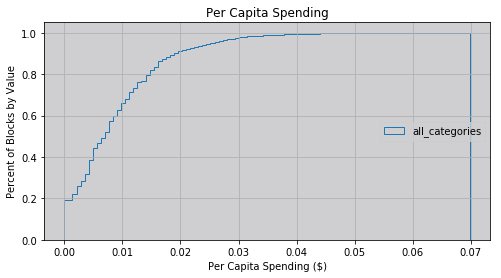

INFO:__main__:Plot was saved to: figures/fig_12.png


In [59]:
PC_w.plot_cdf()

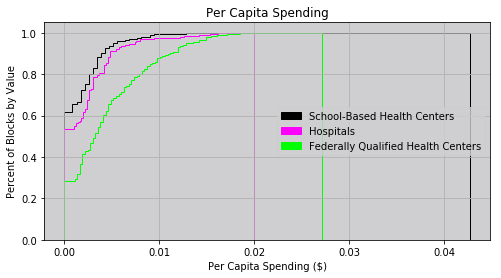

INFO:__main__:Plot was saved to: figures/fig_14.png


In [66]:
PC_w_lim.plot_cdf()

In [ ]:
#Limit targets to categories of type CAT_A and CAT_B for calculating PC walk model.
PC_d = PCSpendModel(network_type='drive', sp_matrix_filename='data/drive_full_results_1.csv', 
        source_filename='resources/LEHD_blocks.csv', dest_filename='resources/marynia_health.csv', limit_categories=set(['CAT_A', 'CAT_B']))
PC_d.calculate()

<a id='notes'></a>

# Technical notes  

#### Installing a fresh copy of Ubuntu 16.04 LTS with pip3
---

1. Follow the instructions at this link: https://linus.nci.nih.gov/bdge/installUbuntu.html
2. Run `sudo apt-get update`
3. Run`sudo add-apt-repository universe`
4. Run`sudo apt-get -y install python3-pip`

## Generate a virtual machine >>>


To do:
Show example of driving
Pending